In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from PIL import Image
import timm
import torch
from tqdm import tqdm
import ast
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

/Users/veeranonthuvasin/Desktop/MSc-Data-Science-Bristol/Dissertation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
writers_info = pd.read_csv('./Final-Data/new-writers-info.csv')
english_writer_info = pd.read_csv('../Data/Bristol-Corpus/English-GrayScale/english_df.csv')

writers_info = pd.concat([writers_info, english_writer_info], axis=0, ignore_index=True)
writers_info = writers_info.loc[writers_info['NativeLanguage'] != 'Swiss German']

writers_info

,name,DayOfBirth,EducationalDegree,Gender,NativeCountry,NativeLanguage,OtherLanguage,Profession,WritingType,Science,WrittenLanguage,ascii_path,images_path,stroke_path
0,10000,1982-06-08,Dipl. Inform.,Male,Germany,German,French,PhD-Student,Right-handed,Mathematics,English,"['./Data/ascii/z01/z01-000/z01-000.txt', './Da...",['./Data/lineImages/z01/z01-000/z01-000-*.tif'...,['./Data/lineStrokes/z01/z01-000/z01-000-*.xml...
1,10002,NaN,NaN,Male,Great Britain,English,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-020/a01-020x.txt', './D...",['./Data/lineImages/a01/a01-020/a01-020x-*.tif...,['./Data/lineStrokes/a01/a01-020/a01-020x-*.xm...
2,10004,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a02/a02-082/a02-082.txt', './Da...",['./Data/lineImages/a02/a02-082/a02-082-*.tif'...,['./Data/lineStrokes/a02/a02-082/a02-082-*.xml...
3,10007,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-014/a01-014.txt', './Da...",['./Data/lineImages/a01/a01-014/a01-014-*.tif'...,['./Data/lineStrokes/a01/a01-014/a01-014-*.xml...
4,10008,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-077/a01-077.txt', './Da...",['./Data/lineImages/a01/a01-077/a01-077-*.tif'...,['./Data/lineStrokes/a01/a01-077/a01-077-*.xml...
5,10009,NaN,NaN,Male,Germany,German,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003.txt', './Da...",['./Data/lineImages/a01/a01-003/a01-003-*.tif'...,['./Data/lineStrokes/a01/a01-003/a01-003-*.xml...
6,10010,NaN,NaN,Male,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-117/a01-117.txt', './Da...",['./Data/lineImages/a01/a01-117/a01-117-*.tif'...,['./Data/lineStrokes/a01/a01-117/a01-117-*.xml...
7,10011,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-000/a01-000u.txt', './D...",['./Data/lineImages/a01/a01-000/a01-000u-*.tif...,['./Data/lineStrokes/a01/a01-000/a01-000u-*.xm...
8,10012,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003x.txt', './D...",['./Data/lineImages/a01/a01-003/a01-003x-*.tif...,['./Data/lineStrokes/a01/a01-003/a01-003x-*.xm...
9,10015,NaN,NaN,Female,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-020/a01-020.txt', './Da...",['./Data/lineImages/a01/a01-020/a01-020-*.tif'...,['./Data/lineStrokes/a01/a01-020/a01-020-*.xml...


In [3]:
writers_info['NativeLanguage'].value_counts()

NativeLanguage
English    22
German     19
French     16
Name: count, dtype: int64

# Utility Functions
- Feature Extraction Functions
- Change writer label

In [ ]:
def feature_extraction(writer_name, images_path):
  model = timm.create_model(
      'convnextv2_nano.fcmae_ft_in22k_in1k',
      pretrained=True,
      num_classes=0,  # remove classifier nn.Linear
  )
  model = model.eval()

  data_config = timm.data.resolve_model_data_config(model)
  transforms = timm.data.create_transform(**data_config, is_training=False)

  all_features_data = []
  writer_id_list = []
  writer_forms_list = []
  for name, i in tqdm(zip(writer_name,images_path)):
      i = ast.literal_eval(i)
      for j in i:
        j = j.replace('./', '../')
        image_list = glob.glob(j)
        for k in image_list:
          with Image.open(k) as img:
              img = img.convert('RGB')
              
              
              with torch.no_grad():
                  output = model(transforms(img).unsqueeze(0))
              # print(output)
              # features = output.pooler_output.detach().numpy()
              # print(features)
              # last_hidden_states = outputs.last_hidden_state
              # print(last_hidden_states.shape)
              # features = last_hidden_states[:, 0, :]
              # print(features)
              # Store the results
              image_form = os.path.splitext(os.path.basename(k))[0]
              writer_forms_list.append(image_form)
              writer_id_list.append(name)
              all_features_data.append(output.detach().flatten().tolist())

              


  writer_features_df = pd.DataFrame(data=all_features_data)
  writer_features_df['name'] = writer_id_list
  writer_features_df['form'] = writer_forms_list
  return writer_features_df

def convert_y(y):
  if y == 'German':
    return 0
  if y == 'French': 
    return 1
  if y == 'English':
    return 2

# Feature Extraction Full

In [ ]:
all_features = feature_extraction(writers_info['name'], writers_info['images_path'])
all_features

In [ ]:
all_features.to_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv')

# Feature Extraction for Training Set (class-wise fixed sizes and bootstrapping)
- 3/4 Sentence-Level Images per Sub-writer Profile, for 6 Sub-writer Profiles.

In [ ]:
def create_sub_writers_bootstrap(train_df, feature_store, images_per_subwriter=4, num_profiles_per_writer=6, fold_seed=42):
   
    writer_names_in_fold = train_df['name'].unique()
    feature_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]

    feature_columns = [col for col in feature_df.columns if col not in ['name', 'form']]
    aggregated_data = []
    
    unique_writers = feature_df['name'].unique()
    
    for writer_id in unique_writers:
        writer_df = feature_df[feature_df['name'] == writer_id]
        num_images = len(writer_df)
        
        if num_images == 0:
            continue

        if num_images <= images_per_subwriter:            
            feature_chunk = writer_df[feature_columns]
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            new_row = {}
            for col in feature_columns:
                new_row[f'{col}|mean'] = mean_features[col]
                new_row[f'{col}|median'] = median_features[col]
                new_row[f'{col}|std'] = std_features[col]
                new_row[f'{col}|skew'] = skew_features[col]
                
            
            new_row['original_writer_id'] = writer_id
            new_row['sub_writer_id'] = f"{writer_id}-agg-0"
            aggregated_data.append(new_row)
            continue


        writer_profiles = []
        
        max_attempts = num_profiles_per_writer * 5
        
        for i in range(max_attempts):
            sample_chunk = writer_df.sample(n=images_per_subwriter, replace=True, random_state=fold_seed + hash(writer_id) % 100000 + i)
            feature_chunk = sample_chunk[feature_columns]
            
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            profile_dict = {}
            for col in feature_columns:
                profile_dict[f'{col}|mean'] = mean_features[col]
                profile_dict[f'{col}|median'] = median_features[col]
                profile_dict[f'{col}|std'] = std_features[col]
                profile_dict[f'{col}|skew'] = skew_features[col]
                
            writer_profiles.append(profile_dict)
            
            temp_df = pd.DataFrame(writer_profiles).drop_duplicates()
            if len(temp_df) >= num_profiles_per_writer:
                break
        
        if writer_profiles:
            profiles_df = pd.DataFrame(writer_profiles)
            unique_profiles_df = profiles_df.drop_duplicates().reset_index(drop=True)
            final_profiles_df = unique_profiles_df.head(num_profiles_per_writer)

            for i, row in final_profiles_df.iterrows():
                profile_data = row.to_dict()
                profile_data['original_writer_id'] = writer_id
                profile_data['sub_writer_id'] = f"{writer_id}-boot-{i}"
                aggregated_data.append(profile_data)
            

    
    final_df = pd.DataFrame(aggregated_data)
    

    new_feature_columns = []
    for col in feature_columns:
        new_feature_columns.append(f'{col}|mean')
        new_feature_columns.append(f'{col}|median')
        new_feature_columns.append(f'{col}|std')
        new_feature_columns.append(f'{col}|skew')

    cols = ['sub_writer_id', 'original_writer_id'] + new_feature_columns
    final_df = final_df[cols]
    
    final_df = pd.merge(final_df, train_df[['name', 'NativeLanguage']], how='inner', left_on='original_writer_id', right_on='name')
    
    X_train = final_df.drop(columns=['sub_writer_id', 'original_writer_id','name','NativeLanguage'])
    y_train = final_df['NativeLanguage']
    y_train = np.vectorize(convert_y)(y_train)
    
    return X_train, y_train


# Feature Extraction for Test set (Writer-Level Profile)

In [ ]:
def create_writer_level_profile(test_df, feature_store):

  writer_names_in_fold = test_df['name'].unique()
  test_features_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]
  
  writer_level_feature_df = test_features_df.groupby(['name'], as_index=False)[test_features_df.columns[:-2]].agg(['mean', 'median', 'std', 'skew']).fillna(0)
  writer_level_feature_df.columns = writer_level_feature_df.columns.map(lambda x: '|'.join(map(str, x)))
  
  final_test_df = pd.merge(writer_level_feature_df, test_df[['name', 'NativeLanguage']], how='inner', left_on='name|', right_on='name')
  
  X_test = final_test_df.drop(columns=['name','name|','NativeLanguage'])
  y_test = final_test_df['NativeLanguage']
  y_test = np.vectorize(convert_y)(y_test)
  
  return X_test, y_test
  
  

## Distribution of Each Sentence-level Images Per Writer Per Class

,name,cnt
count,19.000000,19.000000
mean,10112.473684,60.000000
std,67.104701,19.407902
min,10000.000000,12.000000
25%,10071.500000,53.000000
50%,10104.000000,58.000000
75%,10164.500000,64.000000
max,10220.000000,113.000000


,name,cnt
count,16.000000,16.000000
mean,10045.437500,90.187500
std,68.685728,28.100341
min,10004.000000,45.000000
25%,10010.750000,68.750000
50%,10017.500000,100.000000
75%,10026.000000,110.000000
max,10219.000000,129.000000


,name,cnt
count,22.000000,22.000000
mean,467.227273,11.727273
std,2129.633971,17.216221
min,0.000000,5.000000
25%,7.250000,6.000000
50%,13.500000,7.500000
75%,20.500000,9.750000
max,10002.000000,88.000000


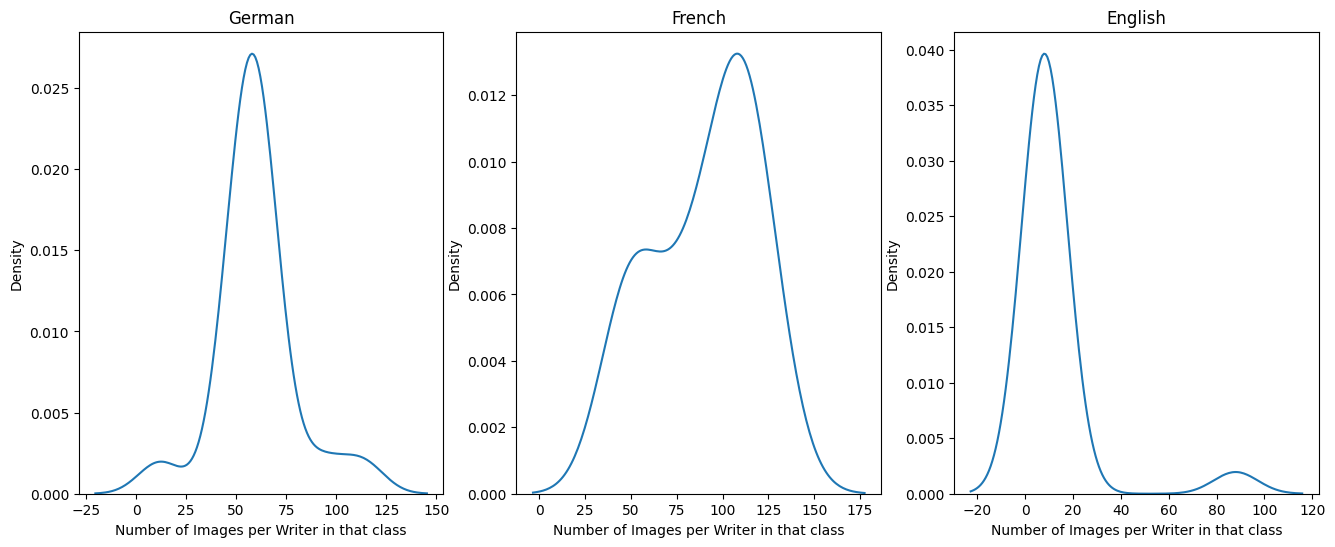

In [9]:
feature_store = pd.read_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv', index_col=[0])
images_per_writer_per_class = feature_store[['name']]
images_per_writer_per_class = pd.merge(images_per_writer_per_class, writers_info[['name', 'NativeLanguage']], how='inner', on='name')

images_per_writer_per_class['cnt'] = 1
images_per_writer_per_class_group = images_per_writer_per_class.groupby(['name','NativeLanguage'], as_index=False).sum()
# display(images_per_writer_per_class_group)

fig, axes = plt.subplots(1, 3, figsize=(16,6))

sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'German']['cnt'], ax=axes[0])
sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'French']['cnt'], ax=axes[1])
sns.kdeplot(data=images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'English']['cnt'], ax=axes[2])

axes[0].set_title('German')
axes[0].set_xlabel('Number of Images per Writer in that class')
axes[1].set_title('French')
axes[1].set_xlabel('Number of Images per Writer in that class')
axes[2].set_title('English')
axes[2].set_xlabel('Number of Images per Writer in that class')

display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'German'].describe())
display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'French'].describe())
display(images_per_writer_per_class_group.loc[images_per_writer_per_class_group['NativeLanguage'] == 'English'].describe())

# Nested Cross-Validation

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
import optuna
from optuna.distributions import FloatDistribution, IntDistribution
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
import json
from collections import defaultdict


feature_store = pd.read_csv('./Final-Data/All-Writers-Feature-Vectors-GrayScale.csv', index_col=[0])
all_writers_info = feature_store[['name']].drop_duplicates().reset_index(drop=True)
all_writers_info = pd.merge(all_writers_info, writers_info[['name', 'NativeLanguage']], how='inner', on='name')
all_labels = all_writers_info['NativeLanguage']

outer_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

results_aggregator = {
    '0': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '1': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '2': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    'accuracy': [],
    'g_mean': [],
    'confusion_matrices': []
}

outer_loop_scores = []
writer_level_results = defaultdict(lambda: {'true': [], 'predicted': []})
print("--- Starting Nested Cross-Validation ---")

# --- The Outer Loop ---
for i, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(all_writers_info, all_labels)):
    outer_test_writers = all_writers_info.iloc[outer_test_idx]
    print("-" * 50)
    print(f"DEBUG: Writers in Outer Test Fold {i+1}: {sorted(outer_test_writers['name'].tolist())}")
    print("-" * 50)
    
    print(f"\nOuter Fold {i+1}/5")
    outer_train_writers, outer_train_labels = all_writers_info.iloc[outer_train_idx], all_labels.iloc[outer_train_idx]
    outer_test_writers, outer_test_labels = all_writers_info.iloc[outer_test_idx], all_labels.iloc[outer_test_idx]
    # display(outer_train_writers)
    # display(outer_train_labels)
    # print(outer_train_writers.shape)
    # print(outer_train_labels.shape)
    # print(outer_test_writers.shape)
    # --- The Inner Loop using Optuna ---
    def objective(trial):
        params = {
            'feature_selection__max_features': trial.suggest_int('feature_selection__max_features', 10, 1000),
            'classification__n_estimators': trial.suggest_int('classification__n_estimators', 50, 1000),
            'classification__learning_rate': trial.suggest_float('classification__learning_rate', 1e-3, 0.5, log=True),
            'classification__max_depth': trial.suggest_int('classification__max_depth', 3, 15),
            'classification__subsample': trial.suggest_float('classification__subsample', 0.6, 1.0),
            'classification__colsample_bytree': trial.suggest_float('classification__colsample_bytree', 0.6, 1.0),
            'classification__lambda': trial.suggest_float('classification__lambda', 0.1, 30.0, log=True),
            'classification__alpha': trial.suggest_float('classification__alpha', 0.1, 20.0, log=True),
            'classification__min_child_weight': trial.suggest_int('classification__min_child_weight', 1, 10)
        }


        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
        ])
        pipeline.set_params(**params)

        # Perform inner cross-validation to evaluate this pipeline configuration
        inner_scores = []
        for j, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(outer_train_writers, outer_train_labels)):
            print(f"    - Trial #{trial.number}, Inner Fold {j+1}/{inner_cv.get_n_splits()}", end='\r')
            inner_train_writers = outer_train_writers.iloc[inner_train_idx]
            inner_val_writers = outer_train_writers.iloc[inner_val_idx]
            # display(inner_train_writers)

            X_inner_train, y_inner_train = create_sub_writers_bootstrap(inner_train_writers, feature_store, fold_seed=j)
            X_inner_val, y_inner_val = create_sub_writers_bootstrap(inner_val_writers, feature_store, fold_seed=j+1000)

            pipeline.fit(X_inner_train, y_inner_train)
            preds = pipeline.predict(X_inner_val)
            inner_scores.append(f1_score(y_inner_val, preds, average='macro'))
        
        # print(inner_scores)
        return np.mean(inner_scores)

    # Create and run the Optuna study to find the best params for this outer fold
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15)
    best_hyperparams = study.best_params
    print(f"  --- Optuna Complete. Best params for this fold: {best_hyperparams} ---")

    # --- Final Training and Evaluation for this Outer Fold ---
    
    X_train_fold, y_train_fold = create_sub_writers_bootstrap(outer_train_writers, feature_store, fold_seed=i)
    X_test_fold, y_test_fold = create_writer_level_profile(outer_test_writers, feature_store)
    

    print(f"\n--- DEBUG DATA FOR FOLD {i+1} ---")
    print(f"Shape of final X_train_fold: {X_train_fold.shape}")
    print(f"Shape of final X_test_fold: {X_test_fold.shape}")
    print(f"Sum of final X_test_fold values: {X_test_fold.to_numpy().sum()}") 
    print("---------------------------------\n")
    
    final_fold_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
    ])
    final_fold_pipeline.set_params(**best_hyperparams)
    
    final_fold_pipeline.fit(X_train_fold, y_train_fold)
    
    predictions = final_fold_pipeline.predict(X_test_fold)
    
    test_writer_ids = outer_test_writers['name'].tolist()
    
    for idx, writer_id in enumerate(test_writer_ids):
        true_label = y_test_fold[idx]
        predicted_label = predictions[idx]
        writer_level_results[writer_id]['true'].append(true_label)
        writer_level_results[writer_id]['predicted'].append(predicted_label)
        

    report = classification_report(y_test_fold, predictions, output_dict=True, zero_division=0)
    g_mean = geometric_mean_score(y_test_fold, predictions, average='macro')
    cm = confusion_matrix(y_test_fold, predictions, labels=[0, 1, 2])
    
    for class_label in ['0', '1', '2']:
        if class_label in report:
            for metric in ['precision', 'recall', 'f1-score', 'support']:
                results_aggregator[class_label][metric].append(report[class_label][metric])
    
    results_aggregator['accuracy'].append(report['accuracy'])
    results_aggregator['g_mean'].append(g_mean)
    results_aggregator['confusion_matrices'].append(cm.tolist())
    
    print(f"  --> Score for this fold (Macro F1): {report['macro avg']['f1-score']:.4f}, (G-Mean): {g_mean:.4f}, (Accuracy): {report['accuracy']}")

    # --- Save progress at the end of each fold ---
    print("  -> Saving progress to cv_results.json...")
    with open('GrayScale-cv_results_fixed_all_4img_6sub-4fold-Final.json', 'w') as f:
        json.dump(results_aggregator, f, indent=4)
    
    # score = f1_score(y_test_fold, predictions, average='macro')
    # outer_loop_scores.append(score)
    # print(f"  Score for Outer Fold {i+1}: {score:.4f}")
    


[I 2025-08-14 00:30:04,662] A new study created in memory with name: no-name-e361535e-bf94-41ce-8b5d-7ed594e40119


--- Starting Nested Cross-Validation ---
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 1: [7, 11, 14, 19, 21, 25, 10000, 10004, 10008, 10032, 10052, 10089, 10108, 10109, 10164]
--------------------------------------------------

Outer Fold 1/5


[I 2025-08-14 00:31:28,561] Trial 0 finished with value: 0.651813091586451 and parameters: {'feature_selection__max_features': 22, 'classification__n_estimators': 824, 'classification__learning_rate': 0.036103784091415465, 'classification__max_depth': 10, 'classification__subsample': 0.8904242254143717, 'classification__colsample_bytree': 0.6801929407763458, 'classification__lambda': 1.8066758317677583, 'classification__alpha': 13.025932221458904, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.651813091586451.


[I 2025-08-14 00:32:51,404] Trial 1 finished with value: 0.6889476357248877 and parameters: {'feature_selection__max_features': 198, 'classification__n_estimators': 704, 'classification__learning_rate': 0.3979374803042275, 'classification__max_depth': 4, 'classification__subsample': 0.9511634090802163, 'classification__colsample_bytree': 0.7889127525699733, 'classification__lambda': 28.409409774567823, 'classification__alpha': 9.880751663252946, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6889476357248877.


[I 2025-08-14 00:34:14,667] Trial 2 finished with value: 0.7298806202142974 and parameters: {'feature_selection__max_features': 277, 'classification__n_estimators': 237, 'classification__learning_rate': 0.0299730142433113, 'classification__max_depth': 3, 'classification__subsample': 0.8692221064055269, 'classification__colsample_bytree': 0.7598582354610356, 'classification__lambda': 28.899629882759626, 'classification__alpha': 5.503278426650554, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7298806202142974.


[I 2025-08-14 00:35:35,886] Trial 3 finished with value: 0.7099749763483608 and parameters: {'feature_selection__max_features': 631, 'classification__n_estimators': 108, 'classification__learning_rate': 0.0018955259650956684, 'classification__max_depth': 3, 'classification__subsample': 0.9940834589712187, 'classification__colsample_bytree': 0.6383622091421438, 'classification__lambda': 2.842886463081565, 'classification__alpha': 1.6390093691664773, 'classification__min_child_weight': 8}. Best is trial 2 with value: 0.7298806202142974.


[I 2025-08-14 00:37:02,659] Trial 4 finished with value: 0.7306439941519822 and parameters: {'feature_selection__max_features': 377, 'classification__n_estimators': 769, 'classification__learning_rate': 0.03721988577206796, 'classification__max_depth': 4, 'classification__subsample': 0.6216619217984795, 'classification__colsample_bytree': 0.9411243251953709, 'classification__lambda': 0.1935419099040088, 'classification__alpha': 7.256501547558627, 'classification__min_child_weight': 7}. Best is trial 4 with value: 0.7306439941519822.


[I 2025-08-14 00:38:24,777] Trial 5 finished with value: 0.7351165071009541 and parameters: {'feature_selection__max_features': 94, 'classification__n_estimators': 280, 'classification__learning_rate': 0.02585854670313573, 'classification__max_depth': 13, 'classification__subsample': 0.6956648329712375, 'classification__colsample_bytree': 0.9970649425923043, 'classification__lambda': 4.330673516393735, 'classification__alpha': 0.5021603363165207, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:39:47,392] Trial 6 finished with value: 0.7275023527699709 and parameters: {'feature_selection__max_features': 883, 'classification__n_estimators': 270, 'classification__learning_rate': 0.07537806745902573, 'classification__max_depth': 11, 'classification__subsample': 0.6290104998862139, 'classification__colsample_bytree': 0.6927036857853783, 'classification__lambda': 0.43814821563212086, 'classification__alpha': 0.6872754544951516, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:41:16,589] Trial 7 finished with value: 0.6534842426999289 and parameters: {'feature_selection__max_features': 714, 'classification__n_estimators': 591, 'classification__learning_rate': 0.005963049380886792, 'classification__max_depth': 13, 'classification__subsample': 0.9767912215640377, 'classification__colsample_bytree': 0.8026708045904634, 'classification__lambda': 4.438416488402822, 'classification__alpha': 19.653331837884597, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:42:43,791] Trial 8 finished with value: 0.7335733069726995 and parameters: {'feature_selection__max_features': 685, 'classification__n_estimators': 778, 'classification__learning_rate': 0.0991419578557168, 'classification__max_depth': 11, 'classification__subsample': 0.852166386369192, 'classification__colsample_bytree': 0.8696207278187374, 'classification__lambda': 1.6206423865539001, 'classification__alpha': 3.332089836209825, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:44:10,124] Trial 9 finished with value: 0.6471445163217698 and parameters: {'feature_selection__max_features': 694, 'classification__n_estimators': 285, 'classification__learning_rate': 0.0022893979002961123, 'classification__max_depth': 14, 'classification__subsample': 0.7741423718813091, 'classification__colsample_bytree': 0.9965412292813951, 'classification__lambda': 18.717213044045632, 'classification__alpha': 16.023825808572344, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:45:34,991] Trial 10 finished with value: 0.6600827693649985 and parameters: {'feature_selection__max_features': 30, 'classification__n_estimators': 427, 'classification__learning_rate': 0.00834840346861687, 'classification__max_depth': 7, 'classification__subsample': 0.7462223152298073, 'classification__colsample_bytree': 0.8996194534970677, 'classification__lambda': 7.195006056769549, 'classification__alpha': 0.11084918882593284, 'classification__min_child_weight': 2}. Best is trial 5 with value: 0.7351165071009541.


[I 2025-08-14 00:47:01,600] Trial 11 finished with value: 0.7414773047328018 and parameters: {'feature_selection__max_features': 491, 'classification__n_estimators': 959, 'classification__learning_rate': 0.13887200740674105, 'classification__max_depth': 15, 'classification__subsample': 0.7018907798389977, 'classification__colsample_bytree': 0.8632687975754771, 'classification__lambda': 0.6840839559563572, 'classification__alpha': 0.7270473176161005, 'classification__min_child_weight': 4}. Best is trial 11 with value: 0.7414773047328018.


[I 2025-08-14 00:48:26,802] Trial 12 finished with value: 0.7299444727619573 and parameters: {'feature_selection__max_features': 438, 'classification__n_estimators': 531, 'classification__learning_rate': 0.3093040531518963, 'classification__max_depth': 15, 'classification__subsample': 0.7111555429539118, 'classification__colsample_bytree': 0.9885543060484834, 'classification__lambda': 0.7127992022897596, 'classification__alpha': 0.4494487621072815, 'classification__min_child_weight': 4}. Best is trial 11 with value: 0.7414773047328018.


[I 2025-08-14 00:49:53,236] Trial 13 finished with value: 0.7311898120658209 and parameters: {'feature_selection__max_features': 970, 'classification__n_estimators': 976, 'classification__learning_rate': 0.16308790533192166, 'classification__max_depth': 13, 'classification__subsample': 0.6778009112319625, 'classification__colsample_bytree': 0.8611710700465092, 'classification__lambda': 0.7896198171262807, 'classification__alpha': 0.31803932855684225, 'classification__min_child_weight': 3}. Best is trial 11 with value: 0.7414773047328018.


[I 2025-08-14 00:51:21,247] Trial 14 finished with value: 0.745762210228145 and parameters: {'feature_selection__max_features': 182, 'classification__n_estimators': 964, 'classification__learning_rate': 0.011150108699294576, 'classification__max_depth': 15, 'classification__subsample': 0.6938877687493624, 'classification__colsample_bytree': 0.9301716464263821, 'classification__lambda': 0.12996450294249565, 'classification__alpha': 1.1787084947113802, 'classification__min_child_weight': 4}. Best is trial 14 with value: 0.745762210228145.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 182, 'classification__n_estimators': 964, 'classification__learning_rate': 0.011150108699294576, 'classification__max_depth': 15, 'classification__subsample': 0.6938877687493624, 'classification__colsample_bytree': 0.9301716464263821, 'classification__lambda': 0.12996450294249565, 'classification__alpha': 1.1787084947113802, 'classification__min_child_weight': 4} ---

--- DEBUG DATA FOR FOLD 1 ---
Shape of final X_train_fold: (252, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 4781.839218638272
---------------------------------



[I 2025-08-14 00:51:51,579] A new study created in memory with name: no-name-2ae67878-a18b-45b5-a989-59f1186aee5b


  --> Score for this fold (Macro F1): 0.7121, (G-Mean): 0.7878, (Accuracy): 0.7333333333333333
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 2: [0, 3, 4, 8, 10, 10007, 10009, 10012, 10015, 10062, 10125, 10177, 10201, 10220]
--------------------------------------------------

Outer Fold 2/5


[I 2025-08-14 00:53:17,849] Trial 0 finished with value: 0.6442539467661232 and parameters: {'feature_selection__max_features': 235, 'classification__n_estimators': 365, 'classification__learning_rate': 0.10387935403463994, 'classification__max_depth': 14, 'classification__subsample': 0.7171453140145426, 'classification__colsample_bytree': 0.9407406799761987, 'classification__lambda': 15.40401323922183, 'classification__alpha': 0.9450006805661969, 'classification__min_child_weight': 7}. Best is trial 0 with value: 0.6442539467661232.


[I 2025-08-14 00:54:42,143] Trial 1 finished with value: 0.5482346796319193 and parameters: {'feature_selection__max_features': 13, 'classification__n_estimators': 363, 'classification__learning_rate': 0.002368789216958759, 'classification__max_depth': 7, 'classification__subsample': 0.6303710202520932, 'classification__colsample_bytree': 0.7121084844125396, 'classification__lambda': 6.607508859806457, 'classification__alpha': 1.064490407590925, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6442539467661232.


[I 2025-08-14 00:56:08,879] Trial 2 finished with value: 0.6512522125922686 and parameters: {'feature_selection__max_features': 575, 'classification__n_estimators': 274, 'classification__learning_rate': 0.04077832552694657, 'classification__max_depth': 4, 'classification__subsample': 0.8418128714669081, 'classification__colsample_bytree': 0.9163636097650164, 'classification__lambda': 0.14953247276162873, 'classification__alpha': 5.2236364178357135, 'classification__min_child_weight': 9}. Best is trial 2 with value: 0.6512522125922686.


[I 2025-08-14 00:57:34,813] Trial 3 finished with value: 0.6686581422692534 and parameters: {'feature_selection__max_features': 388, 'classification__n_estimators': 285, 'classification__learning_rate': 0.012709785625622638, 'classification__max_depth': 11, 'classification__subsample': 0.6303051659489763, 'classification__colsample_bytree': 0.9457013344156401, 'classification__lambda': 17.021553119779778, 'classification__alpha': 0.5771281186660084, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 00:59:06,921] Trial 4 finished with value: 0.6174339388386737 and parameters: {'feature_selection__max_features': 702, 'classification__n_estimators': 330, 'classification__learning_rate': 0.0030323239505669155, 'classification__max_depth': 3, 'classification__subsample': 0.7915907577170718, 'classification__colsample_bytree': 0.796408881628516, 'classification__lambda': 1.6351920726096671, 'classification__alpha': 13.417724995215947, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:00:30,846] Trial 5 finished with value: 0.6028159374701277 and parameters: {'feature_selection__max_features': 20, 'classification__n_estimators': 179, 'classification__learning_rate': 0.2492331761407489, 'classification__max_depth': 3, 'classification__subsample': 0.602281293946836, 'classification__colsample_bytree': 0.8778368143709854, 'classification__lambda': 2.4168443539693585, 'classification__alpha': 2.168724085817007, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:02:15,427] Trial 6 finished with value: 0.6246227636913037 and parameters: {'feature_selection__max_features': 885, 'classification__n_estimators': 762, 'classification__learning_rate': 0.001837467717549849, 'classification__max_depth': 8, 'classification__subsample': 0.9731336109292071, 'classification__colsample_bytree': 0.6720157695035633, 'classification__lambda': 5.675321469791713, 'classification__alpha': 0.7302737111207068, 'classification__min_child_weight': 4}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:03:40,534] Trial 7 finished with value: 0.6295285948616547 and parameters: {'feature_selection__max_features': 755, 'classification__n_estimators': 455, 'classification__learning_rate': 0.2660358752152558, 'classification__max_depth': 15, 'classification__subsample': 0.7199017766428015, 'classification__colsample_bytree': 0.9603259843882073, 'classification__lambda': 0.4650116442810779, 'classification__alpha': 6.3255335247289795, 'classification__min_child_weight': 9}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:05:07,884] Trial 8 finished with value: 0.6639699687139562 and parameters: {'feature_selection__max_features': 667, 'classification__n_estimators': 684, 'classification__learning_rate': 0.1664878593784503, 'classification__max_depth': 6, 'classification__subsample': 0.6654857768421667, 'classification__colsample_bytree': 0.6840708918149849, 'classification__lambda': 0.10549702171938813, 'classification__alpha': 8.020316570467328, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:06:32,515] Trial 9 finished with value: 0.6446198459716751 and parameters: {'feature_selection__max_features': 282, 'classification__n_estimators': 637, 'classification__learning_rate': 0.3298425161258921, 'classification__max_depth': 15, 'classification__subsample': 0.7065827018836065, 'classification__colsample_bytree': 0.734183581051925, 'classification__lambda': 1.1610249598010014, 'classification__alpha': 0.152428669473885, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:08:06,542] Trial 10 finished with value: 0.6487656108800732 and parameters: {'feature_selection__max_features': 403, 'classification__n_estimators': 965, 'classification__learning_rate': 0.008949859026791853, 'classification__max_depth': 11, 'classification__subsample': 0.9337090911127918, 'classification__colsample_bytree': 0.8407455110078912, 'classification__lambda': 20.849216375512388, 'classification__alpha': 0.21467360974521127, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:09:37,377] Trial 11 finished with value: 0.6499265985565607 and parameters: {'feature_selection__max_features': 537, 'classification__n_estimators': 645, 'classification__learning_rate': 0.01645938710598017, 'classification__max_depth': 11, 'classification__subsample': 0.6656894436064643, 'classification__colsample_bytree': 0.6023160464727534, 'classification__lambda': 0.1055233347200161, 'classification__alpha': 0.37751070517169877, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:11:08,351] Trial 12 finished with value: 0.6504885710796974 and parameters: {'feature_selection__max_features': 395, 'classification__n_estimators': 826, 'classification__learning_rate': 0.03999927041394972, 'classification__max_depth': 6, 'classification__subsample': 0.8054930119009046, 'classification__colsample_bytree': 0.7761187856989833, 'classification__lambda': 0.3680252181268753, 'classification__alpha': 2.6317558215535315, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:12:34,756] Trial 13 finished with value: 0.5693034714897712 and parameters: {'feature_selection__max_features': 987, 'classification__n_estimators': 80, 'classification__learning_rate': 0.008516295984172766, 'classification__max_depth': 10, 'classification__subsample': 0.6673269213315874, 'classification__colsample_bytree': 0.6041457866751452, 'classification__lambda': 5.6192286746828355, 'classification__alpha': 19.436320984015413, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.6686581422692534.


[I 2025-08-14 01:14:00,757] Trial 14 finished with value: 0.6405315985689239 and parameters: {'feature_selection__max_features': 685, 'classification__n_estimators': 572, 'classification__learning_rate': 0.08947396576060077, 'classification__max_depth': 12, 'classification__subsample': 0.7822471567684183, 'classification__colsample_bytree': 0.9878628032605054, 'classification__lambda': 0.48182093055782077, 'classification__alpha': 0.43202093544466963, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.6686581422692534.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 388, 'classification__n_estimators': 285, 'classification__learning_rate': 0.012709785625622638, 'classification__max_depth': 11, 'classification__subsample': 0.6303051659489763, 'classification__colsample_bytree': 0.9457013344156401, 'classification__lambda': 17.021553119779778, 'classification__alpha': 0.5771281186660084, 'classification__min_child_weight': 7} ---

--- DEBUG DATA FOR FOLD 2 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4690.712571429492
---------------------------------



[I 2025-08-14 01:14:32,114] A new study created in memory with name: no-name-1d1f6468-7386-4ef9-951f-b2c53306d225


  --> Score for this fold (Macro F1): 0.7090, (G-Mean): 0.7972, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 3: [5, 6, 15, 18, 24, 10017, 10018, 10019, 10020, 10095, 10165, 10204, 10206, 10219]
--------------------------------------------------

Outer Fold 3/5


[I 2025-08-14 01:16:01,706] Trial 0 finished with value: 0.652045177451848 and parameters: {'feature_selection__max_features': 918, 'classification__n_estimators': 714, 'classification__learning_rate': 0.29031132537604537, 'classification__max_depth': 8, 'classification__subsample': 0.7649451952291922, 'classification__colsample_bytree': 0.7318393922664811, 'classification__lambda': 0.2017148681288383, 'classification__alpha': 0.1816585053801938, 'classification__min_child_weight': 4}. Best is trial 0 with value: 0.652045177451848.


[I 2025-08-14 01:17:25,528] Trial 1 finished with value: 0.6568487803477897 and parameters: {'feature_selection__max_features': 85, 'classification__n_estimators': 170, 'classification__learning_rate': 0.18574605173859443, 'classification__max_depth': 15, 'classification__subsample': 0.953156570652571, 'classification__colsample_bytree': 0.7147295195487079, 'classification__lambda': 2.0320501966143425, 'classification__alpha': 0.1861965208769625, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6568487803477897.


[I 2025-08-14 01:18:59,380] Trial 2 finished with value: 0.6743562369569905 and parameters: {'feature_selection__max_features': 947, 'classification__n_estimators': 393, 'classification__learning_rate': 0.0018107839558557455, 'classification__max_depth': 14, 'classification__subsample': 0.6455689232348656, 'classification__colsample_bytree': 0.7106731635173931, 'classification__lambda': 1.0073726028392584, 'classification__alpha': 0.2148692990186948, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:20:33,909] Trial 3 finished with value: 0.5538552113676491 and parameters: {'feature_selection__max_features': 633, 'classification__n_estimators': 909, 'classification__learning_rate': 0.0060318457037504235, 'classification__max_depth': 3, 'classification__subsample': 0.6566436366776603, 'classification__colsample_bytree': 0.8900469724605768, 'classification__lambda': 0.9570307469719331, 'classification__alpha': 19.774562218687308, 'classification__min_child_weight': 6}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:21:59,918] Trial 4 finished with value: 0.6162793951340052 and parameters: {'feature_selection__max_features': 57, 'classification__n_estimators': 985, 'classification__learning_rate': 0.025736984675104622, 'classification__max_depth': 15, 'classification__subsample': 0.9243254252423292, 'classification__colsample_bytree': 0.9295340750780994, 'classification__lambda': 0.23061230232418467, 'classification__alpha': 0.6202314006647984, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:23:24,093] Trial 5 finished with value: 0.6551414087121271 and parameters: {'feature_selection__max_features': 669, 'classification__n_estimators': 174, 'classification__learning_rate': 0.007217907310466642, 'classification__max_depth': 12, 'classification__subsample': 0.6866313189749853, 'classification__colsample_bytree': 0.9975385113169355, 'classification__lambda': 0.1759084217704132, 'classification__alpha': 0.40126502468435515, 'classification__min_child_weight': 9}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:24:46,605] Trial 6 finished with value: 0.6125085635853016 and parameters: {'feature_selection__max_features': 565, 'classification__n_estimators': 66, 'classification__learning_rate': 0.011836498820747604, 'classification__max_depth': 13, 'classification__subsample': 0.8131066219108799, 'classification__colsample_bytree': 0.7997140742887794, 'classification__lambda': 3.062358301696336, 'classification__alpha': 18.311398737185375, 'classification__min_child_weight': 3}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:26:12,727] Trial 7 finished with value: 0.6638120307895851 and parameters: {'feature_selection__max_features': 839, 'classification__n_estimators': 244, 'classification__learning_rate': 0.02245649707956418, 'classification__max_depth': 10, 'classification__subsample': 0.858651513294497, 'classification__colsample_bytree': 0.6570629189966274, 'classification__lambda': 10.776364441150841, 'classification__alpha': 3.846859340145281, 'classification__min_child_weight': 5}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:27:34,447] Trial 8 finished with value: 0.6404726422667308 and parameters: {'feature_selection__max_features': 798, 'classification__n_estimators': 93, 'classification__learning_rate': 0.46341680419096426, 'classification__max_depth': 6, 'classification__subsample': 0.7535784056193556, 'classification__colsample_bytree': 0.6088471348981989, 'classification__lambda': 3.522533472333889, 'classification__alpha': 1.1136987676360082, 'classification__min_child_weight': 9}. Best is trial 2 with value: 0.6743562369569905.


[I 2025-08-14 01:29:08,474] Trial 9 finished with value: 0.6748110540647855 and parameters: {'feature_selection__max_features': 499, 'classification__n_estimators': 405, 'classification__learning_rate': 0.00926143635661661, 'classification__max_depth': 13, 'classification__subsample': 0.8657006169654466, 'classification__colsample_bytree': 0.7742307550885288, 'classification__lambda': 0.1752157118996873, 'classification__alpha': 10.230378149744306, 'classification__min_child_weight': 1}. Best is trial 9 with value: 0.6748110540647855.


[I 2025-08-14 01:30:35,292] Trial 10 finished with value: 0.6522118022769372 and parameters: {'feature_selection__max_features': 346, 'classification__n_estimators': 566, 'classification__learning_rate': 0.07677615845582339, 'classification__max_depth': 11, 'classification__subsample': 0.8697742307315663, 'classification__colsample_bytree': 0.8127374074028635, 'classification__lambda': 24.384970579009764, 'classification__alpha': 5.2222551265415715, 'classification__min_child_weight': 1}. Best is trial 9 with value: 0.6748110540647855.


[I 2025-08-14 01:32:03,156] Trial 11 finished with value: 0.6599208081785798 and parameters: {'feature_selection__max_features': 374, 'classification__n_estimators': 398, 'classification__learning_rate': 0.001336046756514298, 'classification__max_depth': 14, 'classification__subsample': 0.6285681998914392, 'classification__colsample_bytree': 0.7604469835326252, 'classification__lambda': 0.622241176733266, 'classification__alpha': 3.522854276661856, 'classification__min_child_weight': 2}. Best is trial 9 with value: 0.6748110540647855.


[I 2025-08-14 01:33:31,791] Trial 12 finished with value: 0.6026922907034736 and parameters: {'feature_selection__max_features': 415, 'classification__n_estimators': 404, 'classification__learning_rate': 0.0014848819867632032, 'classification__max_depth': 8, 'classification__subsample': 0.9939776645166801, 'classification__colsample_bytree': 0.8450803617292536, 'classification__lambda': 0.6093826709243944, 'classification__alpha': 1.6458208454620438, 'classification__min_child_weight': 6}. Best is trial 9 with value: 0.6748110540647855.


[I 2025-08-14 01:34:55,602] Trial 13 finished with value: 0.6642502022936805 and parameters: {'feature_selection__max_features': 232, 'classification__n_estimators': 382, 'classification__learning_rate': 0.0030778701327347315, 'classification__max_depth': 12, 'classification__subsample': 0.7034323649223058, 'classification__colsample_bytree': 0.6587104895797335, 'classification__lambda': 0.11858878999634447, 'classification__alpha': 0.10659980628654102, 'classification__min_child_weight': 7}. Best is trial 9 with value: 0.6748110540647855.


[I 2025-08-14 01:36:33,655] Trial 14 finished with value: 0.6596560301736663 and parameters: {'feature_selection__max_features': 736, 'classification__n_estimators': 584, 'classification__learning_rate': 0.0025103078874209156, 'classification__max_depth': 13, 'classification__subsample': 0.8416158571153706, 'classification__colsample_bytree': 0.6811374355966625, 'classification__lambda': 0.4417544157194679, 'classification__alpha': 8.809187404842596, 'classification__min_child_weight': 3}. Best is trial 9 with value: 0.6748110540647855.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 499, 'classification__n_estimators': 405, 'classification__learning_rate': 0.00926143635661661, 'classification__max_depth': 13, 'classification__subsample': 0.8657006169654466, 'classification__colsample_bytree': 0.7742307550885288, 'classification__lambda': 0.1752157118996873, 'classification__alpha': 10.230378149744306, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 3 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4968.71525734575
---------------------------------



[I 2025-08-14 01:37:07,791] A new study created in memory with name: no-name-3f69ce37-6643-4314-aedb-f9b26501edc5


  --> Score for this fold (Macro F1): 0.7887, (G-Mean): 0.8362, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 4: [12, 13, 17, 22, 23, 10002, 10010, 10011, 10021, 10024, 10081, 10097, 10104, 10159]
--------------------------------------------------

Outer Fold 4/5


[I 2025-08-14 01:38:35,517] Trial 0 finished with value: 0.6414093459812259 and parameters: {'feature_selection__max_features': 599, 'classification__n_estimators': 397, 'classification__learning_rate': 0.027302550003041676, 'classification__max_depth': 7, 'classification__subsample': 0.6232763456450059, 'classification__colsample_bytree': 0.7182091560236166, 'classification__lambda': 10.027757726671991, 'classification__alpha': 6.558835267033262, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6414093459812259.


[I 2025-08-14 01:40:00,759] Trial 1 finished with value: 0.642925385183721 and parameters: {'feature_selection__max_features': 139, 'classification__n_estimators': 692, 'classification__learning_rate': 0.10467196357565885, 'classification__max_depth': 7, 'classification__subsample': 0.6460305461589173, 'classification__colsample_bytree': 0.8015980873632603, 'classification__lambda': 28.874292647775054, 'classification__alpha': 0.5694375137476679, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.642925385183721.


[I 2025-08-14 01:41:30,191] Trial 2 finished with value: 0.5565230052656919 and parameters: {'feature_selection__max_features': 479, 'classification__n_estimators': 703, 'classification__learning_rate': 0.001066892157427637, 'classification__max_depth': 7, 'classification__subsample': 0.7946223764418827, 'classification__colsample_bytree': 0.7390415192821255, 'classification__lambda': 17.50076527253476, 'classification__alpha': 0.9857621885474069, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.642925385183721.


[I 2025-08-14 01:42:52,538] Trial 3 finished with value: 0.7014950859055467 and parameters: {'feature_selection__max_features': 380, 'classification__n_estimators': 304, 'classification__learning_rate': 0.14398013387550507, 'classification__max_depth': 13, 'classification__subsample': 0.9901731976106911, 'classification__colsample_bytree': 0.6806883368820693, 'classification__lambda': 0.10147096280695514, 'classification__alpha': 0.6761499857782346, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:44:20,105] Trial 4 finished with value: 0.5446803282716596 and parameters: {'feature_selection__max_features': 611, 'classification__n_estimators': 357, 'classification__learning_rate': 0.0013455984486540513, 'classification__max_depth': 10, 'classification__subsample': 0.8215857471628744, 'classification__colsample_bytree': 0.9977966075718074, 'classification__lambda': 0.5695457397267073, 'classification__alpha': 15.174796029837708, 'classification__min_child_weight': 8}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:45:43,940] Trial 5 finished with value: 0.6814307848367087 and parameters: {'feature_selection__max_features': 914, 'classification__n_estimators': 708, 'classification__learning_rate': 0.28391329310499275, 'classification__max_depth': 9, 'classification__subsample': 0.7767304291739556, 'classification__colsample_bytree': 0.7264405835447122, 'classification__lambda': 0.1599834615582924, 'classification__alpha': 0.4270509650597816, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:47:09,921] Trial 6 finished with value: 0.5870735038771485 and parameters: {'feature_selection__max_features': 701, 'classification__n_estimators': 386, 'classification__learning_rate': 0.008209285333567714, 'classification__max_depth': 10, 'classification__subsample': 0.8949610901382318, 'classification__colsample_bytree': 0.6054719513249134, 'classification__lambda': 0.15087696100162748, 'classification__alpha': 8.695184359653002, 'classification__min_child_weight': 9}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:48:37,564] Trial 7 finished with value: 0.579136777217199 and parameters: {'feature_selection__max_features': 538, 'classification__n_estimators': 375, 'classification__learning_rate': 0.0027557761588856665, 'classification__max_depth': 15, 'classification__subsample': 0.725497534886794, 'classification__colsample_bytree': 0.7941489686516727, 'classification__lambda': 0.25664691622967306, 'classification__alpha': 12.038927534758296, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:49:59,844] Trial 8 finished with value: 0.6796806414449622 and parameters: {'feature_selection__max_features': 812, 'classification__n_estimators': 378, 'classification__learning_rate': 0.4659045180573028, 'classification__max_depth': 14, 'classification__subsample': 0.9609336443842914, 'classification__colsample_bytree': 0.8244393990896459, 'classification__lambda': 9.500088561768573, 'classification__alpha': 0.3038148763513467, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:51:23,430] Trial 9 finished with value: 0.5632339863246603 and parameters: {'feature_selection__max_features': 42, 'classification__n_estimators': 570, 'classification__learning_rate': 0.002092524453604641, 'classification__max_depth': 5, 'classification__subsample': 0.8989026725423783, 'classification__colsample_bytree': 0.829539407567414, 'classification__lambda': 13.468445936361524, 'classification__alpha': 2.33150871881485, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:52:45,020] Trial 10 finished with value: 0.6820044345863655 and parameters: {'feature_selection__max_features': 317, 'classification__n_estimators': 62, 'classification__learning_rate': 0.0521618905395216, 'classification__max_depth': 13, 'classification__subsample': 0.9967610998535715, 'classification__colsample_bytree': 0.6055259009726321, 'classification__lambda': 1.7369641741247628, 'classification__alpha': 0.12622957194737935, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:54:06,567] Trial 11 finished with value: 0.6987412943164376 and parameters: {'feature_selection__max_features': 307, 'classification__n_estimators': 73, 'classification__learning_rate': 0.057359591402910685, 'classification__max_depth': 13, 'classification__subsample': 0.9803543898640016, 'classification__colsample_bytree': 0.6048200337613198, 'classification__lambda': 1.7637254750142202, 'classification__alpha': 0.10155578618852124, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:55:28,142] Trial 12 finished with value: 0.6420908025064495 and parameters: {'feature_selection__max_features': 316, 'classification__n_estimators': 134, 'classification__learning_rate': 0.11986410814113264, 'classification__max_depth': 12, 'classification__subsample': 0.9330110313426501, 'classification__colsample_bytree': 0.6626780594040426, 'classification__lambda': 1.5148502128866561, 'classification__alpha': 0.1122002793898063, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:56:52,409] Trial 13 finished with value: 0.6725960709232927 and parameters: {'feature_selection__max_features': 349, 'classification__n_estimators': 226, 'classification__learning_rate': 0.013681291913240044, 'classification__max_depth': 12, 'classification__subsample': 0.998030738793986, 'classification__colsample_bytree': 0.6615840572959519, 'classification__lambda': 2.441816834855493, 'classification__alpha': 2.3107439384020294, 'classification__min_child_weight': 4}. Best is trial 3 with value: 0.7014950859055467.


[I 2025-08-14 01:58:15,029] Trial 14 finished with value: 0.6345434304655242 and parameters: {'feature_selection__max_features': 196, 'classification__n_estimators': 955, 'classification__learning_rate': 0.13039059272664255, 'classification__max_depth': 15, 'classification__subsample': 0.8515932876316319, 'classification__colsample_bytree': 0.6619145934500098, 'classification__lambda': 0.5665116900474276, 'classification__alpha': 0.21064841803539414, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.7014950859055467.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 380, 'classification__n_estimators': 304, 'classification__learning_rate': 0.14398013387550507, 'classification__max_depth': 13, 'classification__subsample': 0.9901731976106911, 'classification__colsample_bytree': 0.6806883368820693, 'classification__lambda': 0.10147096280695514, 'classification__alpha': 0.6761499857782346, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 4 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 5275.653969389161
---------------------------------



[I 2025-08-14 01:58:43,107] A new study created in memory with name: no-name-51d62bcd-9650-45aa-b654-5e57be307983


  --> Score for this fold (Macro F1): 0.9327, (G-Mean): 0.9555, (Accuracy): 0.9285714285714286
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 5: [0, 13, 14, 18, 19, 10002, 10007, 10011, 10012, 10019, 10021, 10109, 10125, 10159, 10165]
--------------------------------------------------

Outer Fold 5/5


[I 2025-08-14 02:00:05,581] Trial 0 finished with value: 0.6486533188351499 and parameters: {'feature_selection__max_features': 785, 'classification__n_estimators': 480, 'classification__learning_rate': 0.04098679203494547, 'classification__max_depth': 4, 'classification__subsample': 0.7584610073677664, 'classification__colsample_bytree': 0.8648600814288634, 'classification__lambda': 0.18288663990227452, 'classification__alpha': 19.2038414418501, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6486533188351499.


[I 2025-08-14 02:01:27,430] Trial 1 finished with value: 0.7014470799724736 and parameters: {'feature_selection__max_features': 780, 'classification__n_estimators': 907, 'classification__learning_rate': 0.2546003242326204, 'classification__max_depth': 5, 'classification__subsample': 0.6143454453968361, 'classification__colsample_bytree': 0.8022401324471372, 'classification__lambda': 3.3334125467926388, 'classification__alpha': 0.23393285010744258, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:02:49,036] Trial 2 finished with value: 0.6899020851561817 and parameters: {'feature_selection__max_features': 485, 'classification__n_estimators': 564, 'classification__learning_rate': 0.07835373138549581, 'classification__max_depth': 8, 'classification__subsample': 0.6143273699560284, 'classification__colsample_bytree': 0.8496918219513775, 'classification__lambda': 26.18275030712368, 'classification__alpha': 0.33404576240819694, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:04:09,794] Trial 3 finished with value: 0.6354337467286637 and parameters: {'feature_selection__max_features': 677, 'classification__n_estimators': 322, 'classification__learning_rate': 0.22992224086002858, 'classification__max_depth': 9, 'classification__subsample': 0.8952659503600771, 'classification__colsample_bytree': 0.8036252835866768, 'classification__lambda': 16.55073970887377, 'classification__alpha': 6.514560342772867, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:05:35,093] Trial 4 finished with value: 0.6534019632965881 and parameters: {'feature_selection__max_features': 388, 'classification__n_estimators': 663, 'classification__learning_rate': 0.0028826594978461546, 'classification__max_depth': 9, 'classification__subsample': 0.6918599141534139, 'classification__colsample_bytree': 0.8376888687890109, 'classification__lambda': 4.948549574445094, 'classification__alpha': 0.9886791209951697, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:07:00,627] Trial 5 finished with value: 0.6632562475342995 and parameters: {'feature_selection__max_features': 884, 'classification__n_estimators': 592, 'classification__learning_rate': 0.03939466646221474, 'classification__max_depth': 15, 'classification__subsample': 0.7032791319602262, 'classification__colsample_bytree': 0.8973845761060667, 'classification__lambda': 13.997683199064895, 'classification__alpha': 15.952915916677044, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:08:19,943] Trial 6 finished with value: 0.6701507512745528 and parameters: {'feature_selection__max_features': 234, 'classification__n_estimators': 196, 'classification__learning_rate': 0.07510246714036929, 'classification__max_depth': 12, 'classification__subsample': 0.631762292576972, 'classification__colsample_bytree': 0.7450532266731038, 'classification__lambda': 1.6578444846635896, 'classification__alpha': 0.22436824738446254, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:09:52,219] Trial 7 finished with value: 0.6884133743575603 and parameters: {'feature_selection__max_features': 562, 'classification__n_estimators': 852, 'classification__learning_rate': 0.009007719419631181, 'classification__max_depth': 3, 'classification__subsample': 0.8432374660927577, 'classification__colsample_bytree': 0.8106615159813035, 'classification__lambda': 5.550691678397313, 'classification__alpha': 0.2831667782377297, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:11:18,289] Trial 8 finished with value: 0.6566905524838303 and parameters: {'feature_selection__max_features': 880, 'classification__n_estimators': 698, 'classification__learning_rate': 0.032558943360104786, 'classification__max_depth': 14, 'classification__subsample': 0.9885993770225956, 'classification__colsample_bytree': 0.869832433286337, 'classification__lambda': 5.0671642145073035, 'classification__alpha': 5.354650440340015, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:12:38,988] Trial 9 finished with value: 0.627758072747636 and parameters: {'feature_selection__max_features': 344, 'classification__n_estimators': 135, 'classification__learning_rate': 0.006327324845068847, 'classification__max_depth': 14, 'classification__subsample': 0.787480529571182, 'classification__colsample_bytree': 0.92163148877869, 'classification__lambda': 0.24463739100059947, 'classification__alpha': 17.40835368340502, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:13:59,354] Trial 10 finished with value: 0.6788285677332038 and parameters: {'feature_selection__max_features': 117, 'classification__n_estimators': 940, 'classification__learning_rate': 0.4814687028612522, 'classification__max_depth': 6, 'classification__subsample': 0.9303767643671712, 'classification__colsample_bytree': 0.6022756445828575, 'classification__lambda': 1.162886652701419, 'classification__alpha': 0.1257831019587922, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:15:22,313] Trial 11 finished with value: 0.6944329974159796 and parameters: {'feature_selection__max_features': 578, 'classification__n_estimators': 807, 'classification__learning_rate': 0.1380091445686524, 'classification__max_depth': 7, 'classification__subsample': 0.6073710674410044, 'classification__colsample_bytree': 0.9810092853249441, 'classification__lambda': 26.859089437104128, 'classification__alpha': 0.804174965739998, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.7014470799724736.


[I 2025-08-14 02:16:44,840] Trial 12 finished with value: 0.7296988748328284 and parameters: {'feature_selection__max_features': 993, 'classification__n_estimators': 994, 'classification__learning_rate': 0.20177319498214374, 'classification__max_depth': 6, 'classification__subsample': 0.67024665861098, 'classification__colsample_bytree': 0.9951476487155252, 'classification__lambda': 0.5977973754931524, 'classification__alpha': 0.9483158435270549, 'classification__min_child_weight': 7}. Best is trial 12 with value: 0.7296988748328284.


[I 2025-08-14 02:18:06,817] Trial 13 finished with value: 0.6853319690233719 and parameters: {'feature_selection__max_features': 999, 'classification__n_estimators': 999, 'classification__learning_rate': 0.45356586002235844, 'classification__max_depth': 5, 'classification__subsample': 0.6894355453881079, 'classification__colsample_bytree': 0.6920550014399391, 'classification__lambda': 0.660456005964536, 'classification__alpha': 1.9737485853291779, 'classification__min_child_weight': 7}. Best is trial 12 with value: 0.7296988748328284.


[I 2025-08-14 02:19:28,680] Trial 14 finished with value: 0.7107368631346961 and parameters: {'feature_selection__max_features': 968, 'classification__n_estimators': 819, 'classification__learning_rate': 0.19162511911973845, 'classification__max_depth': 6, 'classification__subsample': 0.7365591682346599, 'classification__colsample_bytree': 0.9936081685871558, 'classification__lambda': 0.5084328699815325, 'classification__alpha': 0.5364937634510102, 'classification__min_child_weight': 5}. Best is trial 12 with value: 0.7296988748328284.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 993, 'classification__n_estimators': 994, 'classification__learning_rate': 0.20177319498214374, 'classification__max_depth': 6, 'classification__subsample': 0.67024665861098, 'classification__colsample_bytree': 0.9951476487155252, 'classification__lambda': 0.5977973754931524, 'classification__alpha': 0.9483158435270549, 'classification__min_child_weight': 7} ---

--- DEBUG DATA FOR FOLD 5 ---
Shape of final X_train_fold: (252, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 5537.5728216573625
---------------------------------



[I 2025-08-14 02:19:56,949] A new study created in memory with name: no-name-b73e4918-92de-46ff-b136-6143485b30e1


  --> Score for this fold (Macro F1): 0.7955, (G-Mean): 0.8587, (Accuracy): 0.8
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 6: [4, 5, 17, 21, 23, 10004, 10010, 10015, 10018, 10052, 10062, 10089, 10204, 10220]
--------------------------------------------------

Outer Fold 6/5


[I 2025-08-14 02:21:19,320] Trial 0 finished with value: 0.6488175599634447 and parameters: {'feature_selection__max_features': 184, 'classification__n_estimators': 171, 'classification__learning_rate': 0.013173842174368311, 'classification__max_depth': 4, 'classification__subsample': 0.6979388074671717, 'classification__colsample_bytree': 0.7733190675955491, 'classification__lambda': 15.975639015247394, 'classification__alpha': 1.4320365172918366, 'classification__min_child_weight': 4}. Best is trial 0 with value: 0.6488175599634447.


[I 2025-08-14 02:22:41,359] Trial 1 finished with value: 0.6546184367351895 and parameters: {'feature_selection__max_features': 501, 'classification__n_estimators': 218, 'classification__learning_rate': 0.17473963787355087, 'classification__max_depth': 15, 'classification__subsample': 0.6905597400847143, 'classification__colsample_bytree': 0.788810175276279, 'classification__lambda': 15.876175821805006, 'classification__alpha': 0.5595185406570528, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6546184367351895.


[I 2025-08-14 02:24:04,310] Trial 2 finished with value: 0.6650414463195452 and parameters: {'feature_selection__max_features': 203, 'classification__n_estimators': 766, 'classification__learning_rate': 0.19925997073079155, 'classification__max_depth': 14, 'classification__subsample': 0.7243905256694783, 'classification__colsample_bytree': 0.789849868001267, 'classification__lambda': 21.85214143588024, 'classification__alpha': 4.414357704372251, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.6650414463195452.


[I 2025-08-14 02:25:40,288] Trial 3 finished with value: 0.6988504856735199 and parameters: {'feature_selection__max_features': 453, 'classification__n_estimators': 537, 'classification__learning_rate': 0.0017510593107548224, 'classification__max_depth': 7, 'classification__subsample': 0.7092474258995702, 'classification__colsample_bytree': 0.7608217131124698, 'classification__lambda': 0.13228062258176856, 'classification__alpha': 0.7079848018055083, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:27:02,729] Trial 4 finished with value: 0.6708865186372784 and parameters: {'feature_selection__max_features': 662, 'classification__n_estimators': 144, 'classification__learning_rate': 0.136755029675197, 'classification__max_depth': 3, 'classification__subsample': 0.8322571994960422, 'classification__colsample_bytree': 0.9500622905349865, 'classification__lambda': 0.10366746011511781, 'classification__alpha': 3.0867317756531527, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:28:35,156] Trial 5 finished with value: 0.6689228510741514 and parameters: {'feature_selection__max_features': 659, 'classification__n_estimators': 672, 'classification__learning_rate': 0.031916230285626374, 'classification__max_depth': 11, 'classification__subsample': 0.8312324914023227, 'classification__colsample_bytree': 0.9853002860885813, 'classification__lambda': 18.026831959645133, 'classification__alpha': 0.18930721923314045, 'classification__min_child_weight': 4}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:29:57,768] Trial 6 finished with value: 0.6201307444615359 and parameters: {'feature_selection__max_features': 327, 'classification__n_estimators': 139, 'classification__learning_rate': 0.0044016143326242475, 'classification__max_depth': 4, 'classification__subsample': 0.9649038801726658, 'classification__colsample_bytree': 0.6823665403507522, 'classification__lambda': 3.484002711032988, 'classification__alpha': 0.3400219952035859, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:31:19,144] Trial 7 finished with value: 0.574743833719609 and parameters: {'feature_selection__max_features': 25, 'classification__n_estimators': 133, 'classification__learning_rate': 0.05393732691323988, 'classification__max_depth': 10, 'classification__subsample': 0.6133214843075965, 'classification__colsample_bytree': 0.8206558303506193, 'classification__lambda': 1.9021512023978195, 'classification__alpha': 12.012571193644268, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:32:44,618] Trial 8 finished with value: 0.666914922022237 and parameters: {'feature_selection__max_features': 578, 'classification__n_estimators': 378, 'classification__learning_rate': 0.10830915937578553, 'classification__max_depth': 8, 'classification__subsample': 0.95576962614685, 'classification__colsample_bytree': 0.7844084510797538, 'classification__lambda': 1.781933970389619, 'classification__alpha': 0.29768872526906437, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:34:07,279] Trial 9 finished with value: 0.6635997838643481 and parameters: {'feature_selection__max_features': 79, 'classification__n_estimators': 892, 'classification__learning_rate': 0.08279508414190233, 'classification__max_depth': 6, 'classification__subsample': 0.9069341732106297, 'classification__colsample_bytree': 0.6257853295790127, 'classification__lambda': 11.747520505567326, 'classification__alpha': 6.632238581347517, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.6988504856735199.


[I 2025-08-14 02:35:45,842] Trial 10 finished with value: 0.7003416668703073 and parameters: {'feature_selection__max_features': 942, 'classification__n_estimators': 477, 'classification__learning_rate': 0.0010159588189333178, 'classification__max_depth': 7, 'classification__subsample': 0.6026682745437018, 'classification__colsample_bytree': 0.8805248721818112, 'classification__lambda': 0.10754757717851521, 'classification__alpha': 1.0427243567321873, 'classification__min_child_weight': 2}. Best is trial 10 with value: 0.7003416668703073.


[I 2025-08-14 02:37:28,759] Trial 11 finished with value: 0.7003404728894926 and parameters: {'feature_selection__max_features': 980, 'classification__n_estimators': 518, 'classification__learning_rate': 0.0015042686781193942, 'classification__max_depth': 7, 'classification__subsample': 0.607444183507763, 'classification__colsample_bytree': 0.8783265246592862, 'classification__lambda': 0.12135310616089852, 'classification__alpha': 0.9554254607857148, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.7003416668703073.


[I 2025-08-14 02:39:01,381] Trial 12 finished with value: 0.6922296641605338 and parameters: {'feature_selection__max_features': 992, 'classification__n_estimators': 439, 'classification__learning_rate': 0.0010330803163616524, 'classification__max_depth': 6, 'classification__subsample': 0.6277932925489034, 'classification__colsample_bytree': 0.8887971230315014, 'classification__lambda': 0.34898902494257966, 'classification__alpha': 1.4535256126894787, 'classification__min_child_weight': 3}. Best is trial 10 with value: 0.7003416668703073.


[I 2025-08-14 02:40:41,116] Trial 13 finished with value: 0.6983556741372202 and parameters: {'feature_selection__max_features': 994, 'classification__n_estimators': 579, 'classification__learning_rate': 0.004929750873254794, 'classification__max_depth': 12, 'classification__subsample': 0.6008311825859409, 'classification__colsample_bytree': 0.8877767371802735, 'classification__lambda': 0.35846931664190523, 'classification__alpha': 0.12081916334582415, 'classification__min_child_weight': 2}. Best is trial 10 with value: 0.7003416668703073.


[I 2025-08-14 02:42:04,693] Trial 14 finished with value: 0.6780141712823938 and parameters: {'feature_selection__max_features': 848, 'classification__n_estimators': 371, 'classification__learning_rate': 0.49713152499780644, 'classification__max_depth': 9, 'classification__subsample': 0.7711204067349667, 'classification__colsample_bytree': 0.885587972525216, 'classification__lambda': 0.4051661531655571, 'classification__alpha': 0.818871644731073, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.7003416668703073.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 942, 'classification__n_estimators': 477, 'classification__learning_rate': 0.0010159588189333178, 'classification__max_depth': 7, 'classification__subsample': 0.6026682745437018, 'classification__colsample_bytree': 0.8805248721818112, 'classification__lambda': 0.10754757717851521, 'classification__alpha': 1.0427243567321873, 'classification__min_child_weight': 2} ---

--- DEBUG DATA FOR FOLD 6 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4955.991088568564
---------------------------------



[I 2025-08-14 02:42:42,397] A new study created in memory with name: no-name-487097f5-993b-4a99-9861-ae54ddff2e7f


  --> Score for this fold (Macro F1): 0.9259, (G-Mean): 0.9499, (Accuracy): 0.9285714285714286
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 7: [3, 7, 12, 15, 22, 10008, 10009, 10017, 10024, 10095, 10164, 10177, 10206, 10219]
--------------------------------------------------

Outer Fold 7/5


[I 2025-08-14 02:44:09,831] Trial 0 finished with value: 0.5787595774882102 and parameters: {'feature_selection__max_features': 535, 'classification__n_estimators': 590, 'classification__learning_rate': 0.004921873795792671, 'classification__max_depth': 8, 'classification__subsample': 0.6430767168696622, 'classification__colsample_bytree': 0.6940918770091005, 'classification__lambda': 2.3075724894322587, 'classification__alpha': 18.689152531065663, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.5787595774882102.


[I 2025-08-14 02:45:32,615] Trial 1 finished with value: 0.6696709211677493 and parameters: {'feature_selection__max_features': 661, 'classification__n_estimators': 430, 'classification__learning_rate': 0.41726544326859105, 'classification__max_depth': 7, 'classification__subsample': 0.6601269496934473, 'classification__colsample_bytree': 0.9619619816415844, 'classification__lambda': 20.39037996505711, 'classification__alpha': 0.14900046796241473, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:47:08,388] Trial 2 finished with value: 0.6355033325874887 and parameters: {'feature_selection__max_features': 733, 'classification__n_estimators': 684, 'classification__learning_rate': 0.0014944289903212893, 'classification__max_depth': 5, 'classification__subsample': 0.9863428611655927, 'classification__colsample_bytree': 0.8766756463519958, 'classification__lambda': 0.1582497920972922, 'classification__alpha': 3.4038779257342813, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:48:34,195] Trial 3 finished with value: 0.6614366563200396 and parameters: {'feature_selection__max_features': 552, 'classification__n_estimators': 709, 'classification__learning_rate': 0.18760922356090515, 'classification__max_depth': 3, 'classification__subsample': 0.9637699326757566, 'classification__colsample_bytree': 0.6349635426350304, 'classification__lambda': 0.24419031215590176, 'classification__alpha': 14.607413890845486, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:49:59,496] Trial 4 finished with value: 0.6026558221231836 and parameters: {'feature_selection__max_features': 598, 'classification__n_estimators': 498, 'classification__learning_rate': 0.0873315784667612, 'classification__max_depth': 3, 'classification__subsample': 0.842223971194994, 'classification__colsample_bytree': 0.7117741612234929, 'classification__lambda': 3.0060962063322703, 'classification__alpha': 17.087309969194553, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:51:24,506] Trial 5 finished with value: 0.6610554880959617 and parameters: {'feature_selection__max_features': 1000, 'classification__n_estimators': 319, 'classification__learning_rate': 0.3002214114963298, 'classification__max_depth': 4, 'classification__subsample': 0.8962377660439101, 'classification__colsample_bytree': 0.6839895438020532, 'classification__lambda': 0.32626430252444677, 'classification__alpha': 4.8629681993977085, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:52:52,625] Trial 6 finished with value: 0.6663565855090675 and parameters: {'feature_selection__max_features': 228, 'classification__n_estimators': 918, 'classification__learning_rate': 0.0033053781268362874, 'classification__max_depth': 3, 'classification__subsample': 0.8416064451918002, 'classification__colsample_bytree': 0.7580465250355504, 'classification__lambda': 0.6137490035536496, 'classification__alpha': 1.1236193385120887, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:54:22,338] Trial 7 finished with value: 0.6389235985106683 and parameters: {'feature_selection__max_features': 105, 'classification__n_estimators': 846, 'classification__learning_rate': 0.003354774173897146, 'classification__max_depth': 6, 'classification__subsample': 0.8270132846902248, 'classification__colsample_bytree': 0.9038910686961762, 'classification__lambda': 0.9618847066227777, 'classification__alpha': 0.18695683160986695, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:56:02,527] Trial 8 finished with value: 0.648083829216071 and parameters: {'feature_selection__max_features': 876, 'classification__n_estimators': 713, 'classification__learning_rate': 0.0015989931456237916, 'classification__max_depth': 4, 'classification__subsample': 0.7513582318107886, 'classification__colsample_bytree': 0.8681884413738095, 'classification__lambda': 7.878282694947451, 'classification__alpha': 0.748127561196448, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:57:26,160] Trial 9 finished with value: 0.6561678359142536 and parameters: {'feature_selection__max_features': 420, 'classification__n_estimators': 135, 'classification__learning_rate': 0.09940971412300985, 'classification__max_depth': 14, 'classification__subsample': 0.7457231264958362, 'classification__colsample_bytree': 0.9968109746876412, 'classification__lambda': 0.23591037062654754, 'classification__alpha': 5.910959212826319, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 02:58:56,381] Trial 10 finished with value: 0.6624145713064992 and parameters: {'feature_selection__max_features': 295, 'classification__n_estimators': 388, 'classification__learning_rate': 0.02528028313677543, 'classification__max_depth': 12, 'classification__subsample': 0.6222688440900468, 'classification__colsample_bytree': 0.988499500561912, 'classification__lambda': 29.64614198881408, 'classification__alpha': 0.22801943370109548, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 03:00:20,730] Trial 11 finished with value: 0.6335714148627448 and parameters: {'feature_selection__max_features': 53, 'classification__n_estimators': 998, 'classification__learning_rate': 0.016269944860233462, 'classification__max_depth': 8, 'classification__subsample': 0.7173006476713555, 'classification__colsample_bytree': 0.7884420933443697, 'classification__lambda': 0.7979470858206811, 'classification__alpha': 0.626909679615763, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 03:01:47,562] Trial 12 finished with value: 0.6531532442209672 and parameters: {'feature_selection__max_features': 253, 'classification__n_estimators': 273, 'classification__learning_rate': 0.015332067682856403, 'classification__max_depth': 10, 'classification__subsample': 0.6883467231696555, 'classification__colsample_bytree': 0.7879252661588438, 'classification__lambda': 26.59497118377061, 'classification__alpha': 0.1020061629347123, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 03:03:17,523] Trial 13 finished with value: 0.6522175694363528 and parameters: {'feature_selection__max_features': 733, 'classification__n_estimators': 963, 'classification__learning_rate': 0.037491714628980495, 'classification__max_depth': 6, 'classification__subsample': 0.8952606723213281, 'classification__colsample_bytree': 0.7542324624789748, 'classification__lambda': 7.084285654565058, 'classification__alpha': 1.813630933468758, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6696709211677493.


[I 2025-08-14 03:04:42,212] Trial 14 finished with value: 0.6447021743836405 and parameters: {'feature_selection__max_features': 370, 'classification__n_estimators': 500, 'classification__learning_rate': 0.45635820691045825, 'classification__max_depth': 10, 'classification__subsample': 0.7979210992262749, 'classification__colsample_bytree': 0.9279304525683263, 'classification__lambda': 0.5711084484878555, 'classification__alpha': 0.4989947825499664, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6696709211677493.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 661, 'classification__n_estimators': 430, 'classification__learning_rate': 0.41726544326859105, 'classification__max_depth': 7, 'classification__subsample': 0.6601269496934473, 'classification__colsample_bytree': 0.9619619816415844, 'classification__lambda': 20.39037996505711, 'classification__alpha': 0.14900046796241473, 'classification__min_child_weight': 10} ---

--- DEBUG DATA FOR FOLD 7 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4849.646174567529
---------------------------------



[I 2025-08-14 03:05:10,940] A new study created in memory with name: no-name-34545bd1-f7e2-420e-b3d9-19d1ed81c804


  --> Score for this fold (Macro F1): 0.7778, (G-Mean): 0.8379, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 8: [6, 8, 10, 11, 24, 25, 10000, 10020, 10032, 10081, 10097, 10104, 10108, 10201]
--------------------------------------------------

Outer Fold 8/5


[I 2025-08-14 03:06:40,415] Trial 0 finished with value: 0.6545713195831399 and parameters: {'feature_selection__max_features': 559, 'classification__n_estimators': 240, 'classification__learning_rate': 0.007821695182207848, 'classification__max_depth': 14, 'classification__subsample': 0.8120528700298334, 'classification__colsample_bytree': 0.9411309954699485, 'classification__lambda': 2.8187927674706366, 'classification__alpha': 9.1690742146551, 'classification__min_child_weight': 4}. Best is trial 0 with value: 0.6545713195831399.


[I 2025-08-14 03:08:16,687] Trial 1 finished with value: 0.6904726732314072 and parameters: {'feature_selection__max_features': 149, 'classification__n_estimators': 379, 'classification__learning_rate': 0.0015591489672180927, 'classification__max_depth': 13, 'classification__subsample': 0.6322610290364928, 'classification__colsample_bytree': 0.6930017509606834, 'classification__lambda': 0.1558181630018428, 'classification__alpha': 1.3409091638293007, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6904726732314072.


[I 2025-08-14 03:09:45,309] Trial 2 finished with value: 0.6479381350071005 and parameters: {'feature_selection__max_features': 66, 'classification__n_estimators': 983, 'classification__learning_rate': 0.06080554464995661, 'classification__max_depth': 13, 'classification__subsample': 0.7082537174511879, 'classification__colsample_bytree': 0.9402843951050949, 'classification__lambda': 1.048403261320031, 'classification__alpha': 0.5106850665523032, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6904726732314072.


[I 2025-08-14 03:11:15,939] Trial 3 finished with value: 0.6911020404825736 and parameters: {'feature_selection__max_features': 953, 'classification__n_estimators': 386, 'classification__learning_rate': 0.02596774121501288, 'classification__max_depth': 12, 'classification__subsample': 0.6084447913441536, 'classification__colsample_bytree': 0.6099736934733949, 'classification__lambda': 29.30683809305193, 'classification__alpha': 5.142725441046174, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:12:58,843] Trial 4 finished with value: 0.6787382848290925 and parameters: {'feature_selection__max_features': 863, 'classification__n_estimators': 350, 'classification__learning_rate': 0.01146508394163729, 'classification__max_depth': 10, 'classification__subsample': 0.8519786315522633, 'classification__colsample_bytree': 0.7102894796346142, 'classification__lambda': 1.497789513100103, 'classification__alpha': 7.3994703612058625, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:14:24,643] Trial 5 finished with value: 0.6655585323234042 and parameters: {'feature_selection__max_features': 334, 'classification__n_estimators': 198, 'classification__learning_rate': 0.02136861714167854, 'classification__max_depth': 3, 'classification__subsample': 0.923617181789764, 'classification__colsample_bytree': 0.8723440691531195, 'classification__lambda': 0.5400218980703902, 'classification__alpha': 0.15526012232061417, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:15:49,545] Trial 6 finished with value: 0.6575075907992329 and parameters: {'feature_selection__max_features': 210, 'classification__n_estimators': 723, 'classification__learning_rate': 0.16640172453643082, 'classification__max_depth': 5, 'classification__subsample': 0.6822041463845626, 'classification__colsample_bytree': 0.8717518910896329, 'classification__lambda': 0.11616491600710259, 'classification__alpha': 0.12354909869196307, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:17:16,179] Trial 7 finished with value: 0.6654017638260523 and parameters: {'feature_selection__max_features': 309, 'classification__n_estimators': 202, 'classification__learning_rate': 0.0011514231476514034, 'classification__max_depth': 5, 'classification__subsample': 0.8728373600195201, 'classification__colsample_bytree': 0.8115583834417381, 'classification__lambda': 0.27069658533146335, 'classification__alpha': 5.567728496376317, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:18:43,224] Trial 8 finished with value: 0.6384497864161326 and parameters: {'feature_selection__max_features': 384, 'classification__n_estimators': 79, 'classification__learning_rate': 0.002199187794313431, 'classification__max_depth': 10, 'classification__subsample': 0.9666443848293266, 'classification__colsample_bytree': 0.8583154108957732, 'classification__lambda': 0.24091690426928286, 'classification__alpha': 0.29452951248174436, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:20:15,194] Trial 9 finished with value: 0.6459199942790727 and parameters: {'feature_selection__max_features': 519, 'classification__n_estimators': 843, 'classification__learning_rate': 0.04475282993955694, 'classification__max_depth': 15, 'classification__subsample': 0.9753075429624769, 'classification__colsample_bytree': 0.9319503660657502, 'classification__lambda': 0.35758033014067253, 'classification__alpha': 0.8404883138299462, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:21:41,297] Trial 10 finished with value: 0.6271167719421714 and parameters: {'feature_selection__max_features': 986, 'classification__n_estimators': 582, 'classification__learning_rate': 0.36449274470609316, 'classification__max_depth': 8, 'classification__subsample': 0.7412968763408642, 'classification__colsample_bytree': 0.627337887308444, 'classification__lambda': 23.890085816070215, 'classification__alpha': 19.98901677207426, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.6911020404825736.


[I 2025-08-14 03:23:09,663] Trial 11 finished with value: 0.6921087827226625 and parameters: {'feature_selection__max_features': 730, 'classification__n_estimators': 473, 'classification__learning_rate': 0.004342175995766685, 'classification__max_depth': 12, 'classification__subsample': 0.6112423937877357, 'classification__colsample_bytree': 0.6011605960225446, 'classification__lambda': 25.697804356575524, 'classification__alpha': 1.9783141240683446, 'classification__min_child_weight': 8}. Best is trial 11 with value: 0.6921087827226625.


[I 2025-08-14 03:24:37,274] Trial 12 finished with value: 0.6934480230529374 and parameters: {'feature_selection__max_features': 755, 'classification__n_estimators': 520, 'classification__learning_rate': 0.0049924779383777665, 'classification__max_depth': 11, 'classification__subsample': 0.6008659324735409, 'classification__colsample_bytree': 0.6130752090215434, 'classification__lambda': 28.343748287410822, 'classification__alpha': 3.213833425857966, 'classification__min_child_weight': 8}. Best is trial 12 with value: 0.6934480230529374.


[I 2025-08-14 03:26:05,492] Trial 13 finished with value: 0.6909349914641677 and parameters: {'feature_selection__max_features': 721, 'classification__n_estimators': 563, 'classification__learning_rate': 0.004793067904887387, 'classification__max_depth': 11, 'classification__subsample': 0.6665812900597323, 'classification__colsample_bytree': 0.6794475597258018, 'classification__lambda': 7.185361939790921, 'classification__alpha': 1.7645258528674477, 'classification__min_child_weight': 8}. Best is trial 12 with value: 0.6934480230529374.


[I 2025-08-14 03:27:37,922] Trial 14 finished with value: 0.6894568013617942 and parameters: {'feature_selection__max_features': 725, 'classification__n_estimators': 683, 'classification__learning_rate': 0.0039783785837817975, 'classification__max_depth': 8, 'classification__subsample': 0.755589236588318, 'classification__colsample_bytree': 0.7509180614184421, 'classification__lambda': 11.028848663034939, 'classification__alpha': 2.587933683679063, 'classification__min_child_weight': 9}. Best is trial 12 with value: 0.6934480230529374.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 755, 'classification__n_estimators': 520, 'classification__learning_rate': 0.0049924779383777665, 'classification__max_depth': 11, 'classification__subsample': 0.6008659324735409, 'classification__colsample_bytree': 0.6130752090215434, 'classification__lambda': 28.343748287410822, 'classification__alpha': 3.213833425857966, 'classification__min_child_weight': 8} ---

--- DEBUG DATA FOR FOLD 8 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4373.710932009219
---------------------------------



[I 2025-08-14 03:28:12,221] A new study created in memory with name: no-name-8572c752-b39e-40c8-a201-6436ee32b5d8


  --> Score for this fold (Macro F1): 0.6566, (G-Mean): 0.7758, (Accuracy): 0.7142857142857143
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 9: [0, 12, 17, 18, 22, 25, 10007, 10020, 10021, 10032, 10081, 10089, 10165, 10204, 10220]
--------------------------------------------------

Outer Fold 9/5


[I 2025-08-14 03:29:37,104] Trial 0 finished with value: 0.6200063695373176 and parameters: {'feature_selection__max_features': 15, 'classification__n_estimators': 233, 'classification__learning_rate': 0.0027342292016628348, 'classification__max_depth': 13, 'classification__subsample': 0.66220258346533, 'classification__colsample_bytree': 0.6162470211006289, 'classification__lambda': 2.038771818152379, 'classification__alpha': 0.5285856516714491, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6200063695373176.


[I 2025-08-14 03:31:00,551] Trial 1 finished with value: 0.6392792314570621 and parameters: {'feature_selection__max_features': 335, 'classification__n_estimators': 146, 'classification__learning_rate': 0.002642374993054902, 'classification__max_depth': 7, 'classification__subsample': 0.844462909830758, 'classification__colsample_bytree': 0.8318088532845955, 'classification__lambda': 10.953856118712254, 'classification__alpha': 0.10824858156640961, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6392792314570621.


[I 2025-08-14 03:32:28,756] Trial 2 finished with value: 0.6603078377797575 and parameters: {'feature_selection__max_features': 939, 'classification__n_estimators': 429, 'classification__learning_rate': 0.10011577918953558, 'classification__max_depth': 5, 'classification__subsample': 0.6202648270719896, 'classification__colsample_bytree': 0.8814030895996672, 'classification__lambda': 9.328743624386668, 'classification__alpha': 1.412852025361248, 'classification__min_child_weight': 6}. Best is trial 2 with value: 0.6603078377797575.


[I 2025-08-14 03:33:49,536] Trial 3 finished with value: 0.6113233186603299 and parameters: {'feature_selection__max_features': 60, 'classification__n_estimators': 333, 'classification__learning_rate': 0.022520437074635732, 'classification__max_depth': 12, 'classification__subsample': 0.8615447167316244, 'classification__colsample_bytree': 0.8142018509071299, 'classification__lambda': 10.238201689903176, 'classification__alpha': 0.8322880403378884, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.6603078377797575.


[I 2025-08-14 03:35:12,135] Trial 4 finished with value: 0.6099172538399639 and parameters: {'feature_selection__max_features': 594, 'classification__n_estimators': 191, 'classification__learning_rate': 0.3525240913976656, 'classification__max_depth': 14, 'classification__subsample': 0.9697780823105574, 'classification__colsample_bytree': 0.6936389905439554, 'classification__lambda': 1.1565155888390093, 'classification__alpha': 8.984162733191384, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.6603078377797575.


[I 2025-08-14 03:36:46,187] Trial 5 finished with value: 0.5691105136813975 and parameters: {'feature_selection__max_features': 316, 'classification__n_estimators': 699, 'classification__learning_rate': 0.001024475033950427, 'classification__max_depth': 6, 'classification__subsample': 0.9869969400425422, 'classification__colsample_bytree': 0.9317829510530425, 'classification__lambda': 0.3232577992304337, 'classification__alpha': 8.877449971216873, 'classification__min_child_weight': 3}. Best is trial 2 with value: 0.6603078377797575.


[I 2025-08-14 03:38:11,835] Trial 6 finished with value: 0.6475412487351174 and parameters: {'feature_selection__max_features': 606, 'classification__n_estimators': 393, 'classification__learning_rate': 0.012580055812170112, 'classification__max_depth': 4, 'classification__subsample': 0.8916448429451596, 'classification__colsample_bytree': 0.8984350599838454, 'classification__lambda': 2.61116420554573, 'classification__alpha': 0.5317638239330434, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.6603078377797575.


[I 2025-08-14 03:39:36,515] Trial 7 finished with value: 0.6736322047904838 and parameters: {'feature_selection__max_features': 269, 'classification__n_estimators': 961, 'classification__learning_rate': 0.07465235704640423, 'classification__max_depth': 13, 'classification__subsample': 0.6929394909220613, 'classification__colsample_bytree': 0.6878873438926274, 'classification__lambda': 8.209226420046623, 'classification__alpha': 2.58397897491056, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:41:04,936] Trial 8 finished with value: 0.648980626140161 and parameters: {'feature_selection__max_features': 715, 'classification__n_estimators': 909, 'classification__learning_rate': 0.055280465655944196, 'classification__max_depth': 14, 'classification__subsample': 0.7240466851913798, 'classification__colsample_bytree': 0.9083141034894703, 'classification__lambda': 0.25858202030101535, 'classification__alpha': 0.6406611167038359, 'classification__min_child_weight': 2}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:42:30,024] Trial 9 finished with value: 0.5988539914983251 and parameters: {'feature_selection__max_features': 316, 'classification__n_estimators': 162, 'classification__learning_rate': 0.01099474950273137, 'classification__max_depth': 10, 'classification__subsample': 0.8165254968421793, 'classification__colsample_bytree': 0.8377389000035211, 'classification__lambda': 2.407785086800858, 'classification__alpha': 16.024412330008044, 'classification__min_child_weight': 5}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:43:53,313] Trial 10 finished with value: 0.6497464706406766 and parameters: {'feature_selection__max_features': 190, 'classification__n_estimators': 987, 'classification__learning_rate': 0.4909892468169033, 'classification__max_depth': 10, 'classification__subsample': 0.7323748795639218, 'classification__colsample_bytree': 0.7254047338638028, 'classification__lambda': 24.300847917287253, 'classification__alpha': 3.779720261941819, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:45:17,530] Trial 11 finished with value: 0.65205525778716 and parameters: {'feature_selection__max_features': 982, 'classification__n_estimators': 661, 'classification__learning_rate': 0.09903593995350109, 'classification__max_depth': 3, 'classification__subsample': 0.6098843988265117, 'classification__colsample_bytree': 0.7284922890019341, 'classification__lambda': 7.266194848768075, 'classification__alpha': 2.8840700945964906, 'classification__min_child_weight': 6}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:46:42,701] Trial 12 finished with value: 0.6595662059223917 and parameters: {'feature_selection__max_features': 947, 'classification__n_estimators': 529, 'classification__learning_rate': 0.12063898703242862, 'classification__max_depth': 7, 'classification__subsample': 0.6072890340520988, 'classification__colsample_bytree': 0.6030917203964004, 'classification__lambda': 29.39550431992063, 'classification__alpha': 1.8129280439961208, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:48:09,991] Trial 13 finished with value: 0.6529263581987313 and parameters: {'feature_selection__max_features': 775, 'classification__n_estimators': 793, 'classification__learning_rate': 0.04956448855739926, 'classification__max_depth': 11, 'classification__subsample': 0.7032846751140618, 'classification__colsample_bytree': 0.982968037130658, 'classification__lambda': 5.077276232731089, 'classification__alpha': 0.21709135082053901, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.6736322047904838.


[I 2025-08-14 03:49:35,073] Trial 14 finished with value: 0.6867322365311849 and parameters: {'feature_selection__max_features': 480, 'classification__n_estimators': 497, 'classification__learning_rate': 0.21837394775200178, 'classification__max_depth': 8, 'classification__subsample': 0.6659509723466968, 'classification__colsample_bytree': 0.769576007799921, 'classification__lambda': 0.6712177912716002, 'classification__alpha': 1.533440638801615, 'classification__min_child_weight': 1}. Best is trial 14 with value: 0.6867322365311849.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 480, 'classification__n_estimators': 497, 'classification__learning_rate': 0.21837394775200178, 'classification__max_depth': 8, 'classification__subsample': 0.6659509723466968, 'classification__colsample_bytree': 0.769576007799921, 'classification__lambda': 0.6712177912716002, 'classification__alpha': 1.533440638801615, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 9 ---
Shape of final X_train_fold: (252, 2560)
Shape of final X_test_fold: (15, 2560)
Sum of final X_test_fold values: 5043.561351274695
---------------------------------



[I 2025-08-14 03:50:04,786] A new study created in memory with name: no-name-ab1992f9-022f-4b5e-a476-703bf01bb400


  --> Score for this fold (Macro F1): 0.9259, (G-Mean): 0.9513, (Accuracy): 0.9333333333333333
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 10: [5, 8, 10, 19, 10000, 10002, 10004, 10015, 10017, 10024, 10095, 10109, 10159, 10164]
--------------------------------------------------

Outer Fold 10/5


[I 2025-08-14 03:51:35,965] Trial 0 finished with value: 0.6059861159811185 and parameters: {'feature_selection__max_features': 347, 'classification__n_estimators': 476, 'classification__learning_rate': 0.0011543359241095307, 'classification__max_depth': 15, 'classification__subsample': 0.8836487470684466, 'classification__colsample_bytree': 0.972756383376187, 'classification__lambda': 2.5350632720227293, 'classification__alpha': 0.8203522419502802, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.6059861159811185.


[I 2025-08-14 03:53:03,249] Trial 1 finished with value: 0.6569837875121696 and parameters: {'feature_selection__max_features': 23, 'classification__n_estimators': 493, 'classification__learning_rate': 0.0011163821820742693, 'classification__max_depth': 9, 'classification__subsample': 0.8316023907021237, 'classification__colsample_bytree': 0.6772663589382327, 'classification__lambda': 0.11549128719290935, 'classification__alpha': 2.086826640197148, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.6569837875121696.


[I 2025-08-14 03:54:26,252] Trial 2 finished with value: 0.6942013138486035 and parameters: {'feature_selection__max_features': 711, 'classification__n_estimators': 81, 'classification__learning_rate': 0.008692821737937655, 'classification__max_depth': 13, 'classification__subsample': 0.6686624740765177, 'classification__colsample_bytree': 0.6180634420387917, 'classification__lambda': 0.35778364141147556, 'classification__alpha': 1.1861609433974354, 'classification__min_child_weight': 5}. Best is trial 2 with value: 0.6942013138486035.


[I 2025-08-14 03:55:49,950] Trial 3 finished with value: 0.6825637516767027 and parameters: {'feature_selection__max_features': 903, 'classification__n_estimators': 212, 'classification__learning_rate': 0.33499841876398745, 'classification__max_depth': 10, 'classification__subsample': 0.8317112510904998, 'classification__colsample_bytree': 0.7786115717738773, 'classification__lambda': 29.31169760654698, 'classification__alpha': 1.7077726028979243, 'classification__min_child_weight': 6}. Best is trial 2 with value: 0.6942013138486035.


[I 2025-08-14 03:57:18,780] Trial 4 finished with value: 0.6530331018499028 and parameters: {'feature_selection__max_features': 659, 'classification__n_estimators': 783, 'classification__learning_rate': 0.37290313984858114, 'classification__max_depth': 14, 'classification__subsample': 0.9198504135144095, 'classification__colsample_bytree': 0.6009379564541009, 'classification__lambda': 13.156261152838956, 'classification__alpha': 0.4381243049765837, 'classification__min_child_weight': 5}. Best is trial 2 with value: 0.6942013138486035.


[I 2025-08-14 03:58:48,608] Trial 5 finished with value: 0.6325215511580641 and parameters: {'feature_selection__max_features': 519, 'classification__n_estimators': 572, 'classification__learning_rate': 0.001054888623384952, 'classification__max_depth': 14, 'classification__subsample': 0.6052205351706851, 'classification__colsample_bytree': 0.6757399385670492, 'classification__lambda': 3.8280712403501007, 'classification__alpha': 12.12649174662754, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.6942013138486035.


[I 2025-08-14 04:00:14,410] Trial 6 finished with value: 0.6443200807858108 and parameters: {'feature_selection__max_features': 651, 'classification__n_estimators': 243, 'classification__learning_rate': 0.13276310568280472, 'classification__max_depth': 6, 'classification__subsample': 0.7473328780934685, 'classification__colsample_bytree': 0.640761356253797, 'classification__lambda': 0.12199352839180412, 'classification__alpha': 13.924512837638169, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.6942013138486035.


[I 2025-08-14 04:01:41,042] Trial 7 finished with value: 0.6981746114266904 and parameters: {'feature_selection__max_features': 226, 'classification__n_estimators': 243, 'classification__learning_rate': 0.06053899935377249, 'classification__max_depth': 13, 'classification__subsample': 0.6479278336376122, 'classification__colsample_bytree': 0.6452438701056492, 'classification__lambda': 2.4788235346500027, 'classification__alpha': 4.907095749859593, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:03:26,143] Trial 8 finished with value: 0.6594810329918794 and parameters: {'feature_selection__max_features': 921, 'classification__n_estimators': 721, 'classification__learning_rate': 0.0013249316510227636, 'classification__max_depth': 8, 'classification__subsample': 0.6121773261671549, 'classification__colsample_bytree': 0.7999774530386486, 'classification__lambda': 3.6659376418554706, 'classification__alpha': 1.619847051718129, 'classification__min_child_weight': 3}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:04:58,775] Trial 9 finished with value: 0.6781397126816802 and parameters: {'feature_selection__max_features': 711, 'classification__n_estimators': 853, 'classification__learning_rate': 0.06368155597230082, 'classification__max_depth': 13, 'classification__subsample': 0.8519266579015934, 'classification__colsample_bytree': 0.8698448630801081, 'classification__lambda': 3.476979478459037, 'classification__alpha': 0.15069001133603507, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:06:27,892] Trial 10 finished with value: 0.6967162893181521 and parameters: {'feature_selection__max_features': 117, 'classification__n_estimators': 335, 'classification__learning_rate': 0.014555314060171548, 'classification__max_depth': 4, 'classification__subsample': 0.7338756582598397, 'classification__colsample_bytree': 0.7541162141488675, 'classification__lambda': 0.8102459024522454, 'classification__alpha': 5.823590368984495, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:07:55,343] Trial 11 finished with value: 0.6817487622932034 and parameters: {'feature_selection__max_features': 174, 'classification__n_estimators': 318, 'classification__learning_rate': 0.014583635939822476, 'classification__max_depth': 3, 'classification__subsample': 0.7352109579558845, 'classification__colsample_bytree': 0.7428061332585315, 'classification__lambda': 0.8315138161237177, 'classification__alpha': 6.021873648308371, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:09:20,584] Trial 12 finished with value: 0.648855559159582 and parameters: {'feature_selection__max_features': 260, 'classification__n_estimators': 363, 'classification__learning_rate': 0.0426082978058513, 'classification__max_depth': 5, 'classification__subsample': 0.9973223213203108, 'classification__colsample_bytree': 0.7244550070519256, 'classification__lambda': 0.8530740984658933, 'classification__alpha': 4.693592641900646, 'classification__min_child_weight': 10}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:10:44,387] Trial 13 finished with value: 0.6363424029798693 and parameters: {'feature_selection__max_features': 42, 'classification__n_estimators': 50, 'classification__learning_rate': 0.004694587065855985, 'classification__max_depth': 11, 'classification__subsample': 0.6990680695365894, 'classification__colsample_bytree': 0.857116297725996, 'classification__lambda': 1.0012019926161349, 'classification__alpha': 4.95377439172419, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.6981746114266904.


[I 2025-08-14 04:12:09,068] Trial 14 finished with value: 0.6581902067615468 and parameters: {'feature_selection__max_features': 399, 'classification__n_estimators': 198, 'classification__learning_rate': 0.02865976304103539, 'classification__max_depth': 7, 'classification__subsample': 0.7606139620096696, 'classification__colsample_bytree': 0.8727286249099819, 'classification__lambda': 0.3494998741756194, 'classification__alpha': 7.653631485324635, 'classification__min_child_weight': 2}. Best is trial 7 with value: 0.6981746114266904.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 226, 'classification__n_estimators': 243, 'classification__learning_rate': 0.06053899935377249, 'classification__max_depth': 13, 'classification__subsample': 0.6479278336376122, 'classification__colsample_bytree': 0.6452438701056492, 'classification__lambda': 2.4788235346500027, 'classification__alpha': 4.907095749859593, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 10 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 5181.274513654456
---------------------------------



[I 2025-08-14 04:12:37,515] A new study created in memory with name: no-name-5c6953a1-11c2-4b7a-b3d3-4215a94c6ef2


  --> Score for this fold (Macro F1): 0.7887, (G-Mean): 0.8485, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 11: [4, 6, 14, 21, 23, 10008, 10009, 10010, 10052, 10104, 10125, 10177, 10201, 10219]
--------------------------------------------------

Outer Fold 11/5


[I 2025-08-14 04:14:00,641] Trial 0 finished with value: 0.7001306487680193 and parameters: {'feature_selection__max_features': 126, 'classification__n_estimators': 638, 'classification__learning_rate': 0.08260936283588487, 'classification__max_depth': 8, 'classification__subsample': 0.7768914319321105, 'classification__colsample_bytree': 0.8018424148084099, 'classification__lambda': 19.498421653070782, 'classification__alpha': 4.106725368055876, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.7001306487680193.


[I 2025-08-14 04:15:29,998] Trial 1 finished with value: 0.691553635227795 and parameters: {'feature_selection__max_features': 137, 'classification__n_estimators': 961, 'classification__learning_rate': 0.008462467269045214, 'classification__max_depth': 6, 'classification__subsample': 0.9955132559319062, 'classification__colsample_bytree': 0.7597143143170741, 'classification__lambda': 0.1817732715676744, 'classification__alpha': 0.12742785315993635, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.7001306487680193.


[I 2025-08-14 04:16:59,987] Trial 2 finished with value: 0.7230954484707893 and parameters: {'feature_selection__max_features': 510, 'classification__n_estimators': 625, 'classification__learning_rate': 0.42587770100908595, 'classification__max_depth': 15, 'classification__subsample': 0.9734652767559897, 'classification__colsample_bytree': 0.9282943560545664, 'classification__lambda': 21.588349480503815, 'classification__alpha': 0.44471095362222324, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.7230954484707893.


[I 2025-08-14 04:18:26,974] Trial 3 finished with value: 0.6501953939222012 and parameters: {'feature_selection__max_features': 977, 'classification__n_estimators': 52, 'classification__learning_rate': 0.002768314027604441, 'classification__max_depth': 6, 'classification__subsample': 0.6311384515169048, 'classification__colsample_bytree': 0.6208355639169666, 'classification__lambda': 0.3117964515182923, 'classification__alpha': 18.624468577153344, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.7230954484707893.


[I 2025-08-14 04:19:57,732] Trial 4 finished with value: 0.7317387035861879 and parameters: {'feature_selection__max_features': 469, 'classification__n_estimators': 381, 'classification__learning_rate': 0.03094164049257543, 'classification__max_depth': 10, 'classification__subsample': 0.7113969983869111, 'classification__colsample_bytree': 0.6132410450526207, 'classification__lambda': 0.2176091051583937, 'classification__alpha': 0.2951567607132024, 'classification__min_child_weight': 2}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:21:30,193] Trial 5 finished with value: 0.6918185924312746 and parameters: {'feature_selection__max_features': 903, 'classification__n_estimators': 865, 'classification__learning_rate': 0.16409003304533984, 'classification__max_depth': 14, 'classification__subsample': 0.9747746723483658, 'classification__colsample_bytree': 0.6703158954815537, 'classification__lambda': 1.7005861184038722, 'classification__alpha': 1.236541757176493, 'classification__min_child_weight': 8}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:23:00,003] Trial 6 finished with value: 0.7276113482835423 and parameters: {'feature_selection__max_features': 663, 'classification__n_estimators': 261, 'classification__learning_rate': 0.2301553133309905, 'classification__max_depth': 8, 'classification__subsample': 0.713848038061253, 'classification__colsample_bytree': 0.8021597074049522, 'classification__lambda': 20.207658844168567, 'classification__alpha': 6.15719059276755, 'classification__min_child_weight': 9}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:24:36,322] Trial 7 finished with value: 0.7185950878266573 and parameters: {'feature_selection__max_features': 398, 'classification__n_estimators': 771, 'classification__learning_rate': 0.0013406781431254497, 'classification__max_depth': 7, 'classification__subsample': 0.6916478451363063, 'classification__colsample_bytree': 0.6909503492946585, 'classification__lambda': 0.11968500879984889, 'classification__alpha': 9.475468995265711, 'classification__min_child_weight': 10}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:26:12,538] Trial 8 finished with value: 0.7011868819854543 and parameters: {'feature_selection__max_features': 184, 'classification__n_estimators': 829, 'classification__learning_rate': 0.010003759668478437, 'classification__max_depth': 8, 'classification__subsample': 0.9703866554204942, 'classification__colsample_bytree': 0.7809716220432659, 'classification__lambda': 18.317223388799814, 'classification__alpha': 0.21826008940549724, 'classification__min_child_weight': 4}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:27:46,461] Trial 9 finished with value: 0.6852131992275128 and parameters: {'feature_selection__max_features': 636, 'classification__n_estimators': 966, 'classification__learning_rate': 0.058740151445378495, 'classification__max_depth': 4, 'classification__subsample': 0.9474769723871729, 'classification__colsample_bytree': 0.9661026382739692, 'classification__lambda': 9.086746685158507, 'classification__alpha': 7.668197516605909, 'classification__min_child_weight': 2}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:29:17,546] Trial 10 finished with value: 0.7102884725588158 and parameters: {'feature_selection__max_features': 349, 'classification__n_estimators': 343, 'classification__learning_rate': 0.024822549393031593, 'classification__max_depth': 12, 'classification__subsample': 0.8660824738133645, 'classification__colsample_bytree': 0.8765623822642269, 'classification__lambda': 0.690881518746918, 'classification__alpha': 0.9279433691362191, 'classification__min_child_weight': 1}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:30:45,166] Trial 11 finished with value: 0.7081828689890511 and parameters: {'feature_selection__max_features': 721, 'classification__n_estimators': 314, 'classification__learning_rate': 0.3633520935837708, 'classification__max_depth': 11, 'classification__subsample': 0.7499789646988554, 'classification__colsample_bytree': 0.871790605247926, 'classification__lambda': 4.8543236951678574, 'classification__alpha': 2.6239105783539602, 'classification__min_child_weight': 3}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:32:10,037] Trial 12 finished with value: 0.719240292534954 and parameters: {'feature_selection__max_features': 754, 'classification__n_estimators': 338, 'classification__learning_rate': 0.030351267905625444, 'classification__max_depth': 10, 'classification__subsample': 0.6972738878773194, 'classification__colsample_bytree': 0.7267034116184226, 'classification__lambda': 2.343462318138974, 'classification__alpha': 0.5290591958139054, 'classification__min_child_weight': 6}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:33:35,496] Trial 13 finished with value: 0.7010859513010493 and parameters: {'feature_selection__max_features': 555, 'classification__n_estimators': 150, 'classification__learning_rate': 0.14401161449980623, 'classification__max_depth': 3, 'classification__subsample': 0.8368534266218377, 'classification__colsample_bytree': 0.8416767359426782, 'classification__lambda': 0.6409500130538967, 'classification__alpha': 2.5236164573703284, 'classification__min_child_weight': 1}. Best is trial 4 with value: 0.7317387035861879.


[I 2025-08-14 04:35:05,535] Trial 14 finished with value: 0.7470834394210101 and parameters: {'feature_selection__max_features': 340, 'classification__n_estimators': 451, 'classification__learning_rate': 0.010103076077456105, 'classification__max_depth': 12, 'classification__subsample': 0.6157463749230103, 'classification__colsample_bytree': 0.6412624363584523, 'classification__lambda': 1.4645429931634864, 'classification__alpha': 0.26987122935903557, 'classification__min_child_weight': 4}. Best is trial 14 with value: 0.7470834394210101.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 340, 'classification__n_estimators': 451, 'classification__learning_rate': 0.010103076077456105, 'classification__max_depth': 12, 'classification__subsample': 0.6157463749230103, 'classification__colsample_bytree': 0.6412624363584523, 'classification__lambda': 1.4645429931634864, 'classification__alpha': 0.26987122935903557, 'classification__min_child_weight': 4} ---

--- DEBUG DATA FOR FOLD 11 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4811.83832263543
---------------------------------



[I 2025-08-14 04:35:40,452] A new study created in memory with name: no-name-fe610041-2a44-429c-b754-2712dca96a19


  --> Score for this fold (Macro F1): 0.8500, (G-Mean): 0.8889, (Accuracy): 0.8571428571428571
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 12: [3, 7, 11, 13, 15, 24, 10011, 10012, 10018, 10019, 10062, 10097, 10108, 10206]
--------------------------------------------------

Outer Fold 12/5


[I 2025-08-14 04:37:10,523] Trial 0 finished with value: 0.6644209486097729 and parameters: {'feature_selection__max_features': 357, 'classification__n_estimators': 339, 'classification__learning_rate': 0.0034600828623972957, 'classification__max_depth': 3, 'classification__subsample': 0.9973259953768939, 'classification__colsample_bytree': 0.704826329022243, 'classification__lambda': 7.013021428588402, 'classification__alpha': 0.4543404209691938, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.6644209486097729.


[I 2025-08-14 04:38:35,129] Trial 1 finished with value: 0.6719237039789959 and parameters: {'feature_selection__max_features': 407, 'classification__n_estimators': 166, 'classification__learning_rate': 0.09511086430912094, 'classification__max_depth': 9, 'classification__subsample': 0.7910094578166786, 'classification__colsample_bytree': 0.8615596711261664, 'classification__lambda': 0.30610240056661053, 'classification__alpha': 0.8512316385710235, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.6719237039789959.


[I 2025-08-14 04:40:02,805] Trial 2 finished with value: 0.6713926461503834 and parameters: {'feature_selection__max_features': 897, 'classification__n_estimators': 123, 'classification__learning_rate': 0.1313733785380299, 'classification__max_depth': 11, 'classification__subsample': 0.823524074965505, 'classification__colsample_bytree': 0.6439944330810518, 'classification__lambda': 0.4916920589240477, 'classification__alpha': 14.397707798935118, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6719237039789959.


[I 2025-08-14 04:41:30,076] Trial 3 finished with value: 0.6536991054690372 and parameters: {'feature_selection__max_features': 866, 'classification__n_estimators': 350, 'classification__learning_rate': 0.06937551724410591, 'classification__max_depth': 4, 'classification__subsample': 0.7108882583184941, 'classification__colsample_bytree': 0.9651299910300634, 'classification__lambda': 0.26134748662304863, 'classification__alpha': 0.5409343597033469, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.6719237039789959.


[I 2025-08-14 04:43:00,105] Trial 4 finished with value: 0.6751039303562294 and parameters: {'feature_selection__max_features': 910, 'classification__n_estimators': 401, 'classification__learning_rate': 0.07957800880230165, 'classification__max_depth': 15, 'classification__subsample': 0.7845613852401734, 'classification__colsample_bytree': 0.945782944291148, 'classification__lambda': 8.399527059625502, 'classification__alpha': 14.303897544384116, 'classification__min_child_weight': 3}. Best is trial 4 with value: 0.6751039303562294.


[I 2025-08-14 04:44:27,774] Trial 5 finished with value: 0.6655980845463458 and parameters: {'feature_selection__max_features': 21, 'classification__n_estimators': 548, 'classification__learning_rate': 0.18286968446568605, 'classification__max_depth': 6, 'classification__subsample': 0.799527227169197, 'classification__colsample_bytree': 0.7871057224848715, 'classification__lambda': 0.6796028709347355, 'classification__alpha': 6.3946958200515125, 'classification__min_child_weight': 8}. Best is trial 4 with value: 0.6751039303562294.


[I 2025-08-14 04:46:01,823] Trial 6 finished with value: 0.6691792985812385 and parameters: {'feature_selection__max_features': 529, 'classification__n_estimators': 669, 'classification__learning_rate': 0.004006277249619171, 'classification__max_depth': 12, 'classification__subsample': 0.8523703355657781, 'classification__colsample_bytree': 0.763190581551598, 'classification__lambda': 7.51403013416601, 'classification__alpha': 15.939908902585302, 'classification__min_child_weight': 10}. Best is trial 4 with value: 0.6751039303562294.


[I 2025-08-14 04:47:34,034] Trial 7 finished with value: 0.6928396916168369 and parameters: {'feature_selection__max_features': 830, 'classification__n_estimators': 748, 'classification__learning_rate': 0.0026400271600052717, 'classification__max_depth': 9, 'classification__subsample': 0.7331583677663944, 'classification__colsample_bytree': 0.6268706434855067, 'classification__lambda': 0.9393499819273283, 'classification__alpha': 0.542503720161007, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.6928396916168369.


[I 2025-08-14 04:48:56,707] Trial 8 finished with value: 0.6712782899753559 and parameters: {'feature_selection__max_features': 515, 'classification__n_estimators': 247, 'classification__learning_rate': 0.17491197187535484, 'classification__max_depth': 14, 'classification__subsample': 0.9783048202943588, 'classification__colsample_bytree': 0.8938808221123264, 'classification__lambda': 5.709712304430261, 'classification__alpha': 2.360119217841684, 'classification__min_child_weight': 9}. Best is trial 7 with value: 0.6928396916168369.


[I 2025-08-14 04:50:20,718] Trial 9 finished with value: 0.6700078289716503 and parameters: {'feature_selection__max_features': 516, 'classification__n_estimators': 423, 'classification__learning_rate': 0.035927545221681, 'classification__max_depth': 14, 'classification__subsample': 0.7846576711932529, 'classification__colsample_bytree': 0.8082184682396023, 'classification__lambda': 0.10533565260589331, 'classification__alpha': 0.13046733897457446, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.6928396916168369.


[I 2025-08-14 04:52:04,590] Trial 10 finished with value: 0.6995083717174913 and parameters: {'feature_selection__max_features': 681, 'classification__n_estimators': 988, 'classification__learning_rate': 0.0011784478548235553, 'classification__max_depth': 8, 'classification__subsample': 0.6362037212199803, 'classification__colsample_bytree': 0.6029105946800069, 'classification__lambda': 26.775310021932462, 'classification__alpha': 0.1515215809795998, 'classification__min_child_weight': 2}. Best is trial 10 with value: 0.6995083717174913.


[I 2025-08-14 04:53:55,475] Trial 11 finished with value: 0.6954357943873775 and parameters: {'feature_selection__max_features': 731, 'classification__n_estimators': 999, 'classification__learning_rate': 0.0010254374896048488, 'classification__max_depth': 8, 'classification__subsample': 0.6066530371909982, 'classification__colsample_bytree': 0.6073071421364269, 'classification__lambda': 29.57401626268416, 'classification__alpha': 0.11963570732945664, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6995083717174913.


[I 2025-08-14 04:55:44,479] Trial 12 finished with value: 0.696424966701668 and parameters: {'feature_selection__max_features': 736, 'classification__n_estimators': 925, 'classification__learning_rate': 0.0013713479277779501, 'classification__max_depth': 7, 'classification__subsample': 0.6238699594680066, 'classification__colsample_bytree': 0.6000606465344626, 'classification__lambda': 29.124186132642297, 'classification__alpha': 0.11289566981056595, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6995083717174913.


[I 2025-08-14 04:57:33,699] Trial 13 finished with value: 0.6991711976698789 and parameters: {'feature_selection__max_features': 683, 'classification__n_estimators': 982, 'classification__learning_rate': 0.009798606662626053, 'classification__max_depth': 6, 'classification__subsample': 0.6401445557369779, 'classification__colsample_bytree': 0.695990047353978, 'classification__lambda': 25.246036686566836, 'classification__alpha': 0.2507366679550471, 'classification__min_child_weight': 1}. Best is trial 10 with value: 0.6995083717174913.


[I 2025-08-14 04:59:06,566] Trial 14 finished with value: 0.7122682349263094 and parameters: {'feature_selection__max_features': 677, 'classification__n_estimators': 847, 'classification__learning_rate': 0.010416379910544398, 'classification__max_depth': 5, 'classification__subsample': 0.662120477788452, 'classification__colsample_bytree': 0.6935256106123416, 'classification__lambda': 2.7803358670338603, 'classification__alpha': 0.2811412175331064, 'classification__min_child_weight': 3}. Best is trial 14 with value: 0.7122682349263094.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 677, 'classification__n_estimators': 847, 'classification__learning_rate': 0.010416379910544398, 'classification__max_depth': 5, 'classification__subsample': 0.662120477788452, 'classification__colsample_bytree': 0.6935256106123416, 'classification__lambda': 2.7803358670338603, 'classification__alpha': 0.2811412175331064, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 12 ---
Shape of final X_train_fold: (258, 2560)
Shape of final X_test_fold: (14, 2560)
Sum of final X_test_fold values: 4680.2468292380945
---------------------------------

  --> Score for this fold (Macro F1): 0.7753, (G-Mean): 0.8367, (Accuracy): 0.7857142857142857
  -> Saving progress to cv_results.json...


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
import optuna
from optuna.distributions import FloatDistribution, IntDistribution
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
import json
from collections import defaultdict


print("\n--- Final Averaged Classification Report ---")

report_data = []

# --- Per-Class Metrics ---
for label in ['0', '1', '2']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    report_data.append({
        '': f"class {label}",
        'precision': f"{p_mean:.2f} (+/- {p_std:.2f})",
        'recall': f"{r_mean:.2f} (+/- {r_std:.2f})",
        'f1-score': f"{f1_mean:.2f} (+/- {f1_std:.2f})",
        'support': f"{support:.0f}"
    })

# --- Overall & Averaged Metrics ---
accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

# Calculate macro averages for precision and recall from their per-class means
macro_p_mean = np.mean([np.mean(results_aggregator[l]['precision']) for l in ['0', '1', '2']])
macro_r_mean = np.mean([np.mean(results_aggregator[l]['recall']) for l in ['0', '1', '2']])
macro_f1_mean = np.mean([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1', '2']])

# Calculate weighted averages
class_supports = [np.sum(results_aggregator[l]['support']) for l in ['0', '1', '2']]
total_support = np.sum(class_supports)
weighted_p_mean = np.average([np.mean(results_aggregator[l]['precision']) for l in ['0', '1', '2']], weights=class_supports)
weighted_r_mean = np.average([np.mean(results_aggregator[l]['recall']) for l in ['0', '1', '2']], weights=class_supports)
weighted_f1_mean = np.average([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1', '2']], weights=class_supports)

report_data.append({'': ''})

report_data.append({'': 'accuracy', 'f1-score': f"{accuracy_mean:.2f} (+/- {accuracy_std:.2f})", 'support': f"{total_support:.0f}"})
report_data.append({'': 'g-mean', 'f1-score': f"{g_mean_mean:.2f} (+/- {g_mean_std:.2f})"})
report_data.append({'': 'macro avg', 'precision': f"{macro_p_mean:.2f}", 'recall': f"{macro_r_mean:.2f}", 'f1-score': f"{macro_f1_mean:.2f}", 'support': f"{total_support:.0f}"})
report_data.append({'': 'weighted avg', 'precision': f"{weighted_p_mean:.2f}", 'recall': f"{weighted_r_mean:.2f}", 'f1-score': f"{weighted_f1_mean:.2f}", 'support': f"{total_support:.0f}"})

final_report_df = pd.DataFrame(report_data).set_index('')
print(final_report_df.fillna('').to_string())



--- Final Averaged Classification Report ---
                    precision           recall         f1-score support
                                                                       
class 0       0.85 (+/- 0.16)  0.75 (+/- 0.17)  0.77 (+/- 0.11)      57
class 1       0.65 (+/- 0.12)  0.81 (+/- 0.23)  0.70 (+/- 0.16)      48
class 2       1.00 (+/- 0.00)  0.88 (+/- 0.09)  0.93 (+/- 0.05)      66
                                                                       
accuracy                                        0.81 (+/- 0.08)     171
g-mean                                          0.86 (+/- 0.06)        
macro avg                0.83             0.81             0.80     171
weighted avg             0.85             0.82             0.82     171


In [ ]:
print("\n--- Final Averaged Performance Metrics ---")

index = ['Class 0 (German)', 'Class 1 (French)', 'Class 2 (English)']
data = {
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Support': []
}

# --- Per-Class Metrics ---
for label in ['0', '1', '2']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    data['Precision'].append(f"{p_mean:.3f} (+/- {p_std:.3f})")
    data['Recall'].append(f"{r_mean:.3f} (+/- {r_std:.3f})")
    data['F1-Score'].append(f"{f1_mean:.3f} (+/- {f1_std:.3f})")
    data['Support'].append(f"{support:.0f}")

final_report_df = pd.DataFrame(data, index=index)
display(final_report_df)
print("-" * 60)

accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

print(f"Overall Accuracy: {accuracy_mean:.3f} (+/- {accuracy_std:.3f})")
print(f"Overall G-Mean:   {g_mean_mean:.3f} (+/- {g_mean_std:.3f})")



--- Final Averaged Performance Metrics ---


,Precision,Recall,F1-Score,Support
Class 0 (German),0.850 (+/- 0.159),0.746 (+/- 0.165),0.771 (+/- 0.108),57
Class 1 (French),0.645 (+/- 0.120),0.812 (+/- 0.231),0.705 (+/- 0.156),48
Class 2 (English),1.000 (+/- 0.000),0.881 (+/- 0.085),0.934 (+/- 0.047),66


------------------------------------------------------------
Overall Accuracy: 0.813 (+/- 0.078)
Overall G-Mean:   0.860 (+/- 0.061)



Aggregated Confusion Matrix Across All Folds:


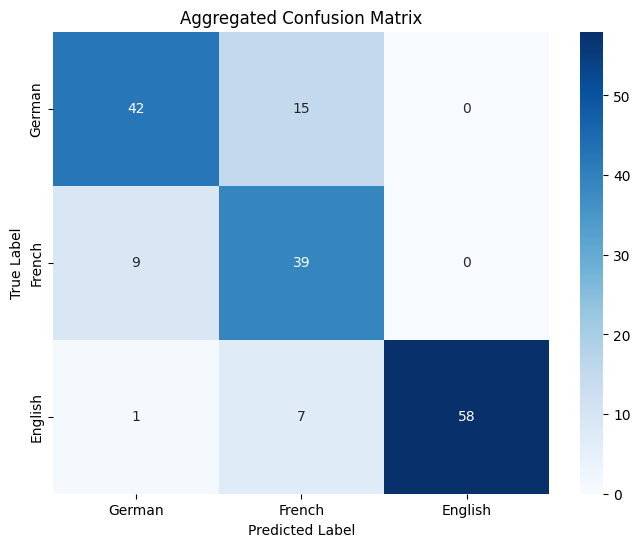

In [ ]:
print("\nAggregated Confusion Matrix Across All Folds:")

# Check if the confusion matrices list exists and is not empty
if 'confusion_matrices' in results_aggregator and results_aggregator['confusion_matrices']:
    total_cm = np.sum(np.array(results_aggregator['confusion_matrices']), axis=0)

    class_labels = ['German', 'French', 'English']

    plt.figure(figsize=(8, 6))
    sns.heatmap(total_cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Aggregated Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No confusion matrix data available to plot.")

